# EC HW4
**Stu. Name:** Mohammad Amin Dadgar

**Stu. Id:** 4003624016

First we'll import the requiered functions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import json
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
from generate_population_scripts import (generate_population,
                                         evaluate_distance_fitness, 
                                         evaluate_fitness_customers_count,
                                         evaluate_fitness_customers_served_demands,
                                         evaluate_fitness_vehicle_count,
                                         find_depot_using,
                                         get_evalution_count, 
                                         set_evaluation_count,
                                         multi_objective_fitness_coeff, 
                                         multi_objective_fitness)
from combination import cut_and_crossfill, mutation_inverse, mutation_scramble
from selection import roulette_wheel, binary_tournament
from multi_objective_handelers import find_pareto_set

The whole algorithm as a function.

In [147]:
def algorithm_run(pop_count, 
                  dataset, 
                  depot_location_dict, 
                  vehicle_count, 
                  selection_method, 
                  FITNESS_FUNCTIONS, 
                  MUTATION_METHOD, 
                  RECOMBINATION_METHOD, 
                  max_capacity=None, 
                  max_distance=None, 
                  p_m=0.1,
                  p_c =0.9,
                  max_evaluations = 5000,
                  vehicle_depot_constraint=True,
                  all_customers=True,
                  multi_objective_handler='coeff'):
    """
    one constraint should be always given as input, the maximum capacity or maximum distance
    for the parameter `FITNESS_FUNCTIONS` if it was a list of fitness functions, then we would assume the problem as multi-objective problem else it is a single objective problem
    
    multi_objective handler can be using coefficients or an algorithm like NSGA-II in which pareto-set is calculated
    """
    ## reset the evaluation counts
    set_evaluation_count(0)
    
    population, fitness_pop = generate_population(max_capacity=max_capacity,
                                                     max_distance=max_distance,
                                                     depot_location_dict= depot_location_dict,
                                                     dataset=dataset, 
                                                     pop_count= pop_count,
                                                     vehicle_count= vehicle_count, 
                                                     fitness_functions = FITNESS_FUNCTIONS, 
                                                     vehicle_depot_constraint = vehicle_depot_constraint,
                                                     all_customers=all_customers, 
                                                     multi_objective_handler = multi_objective_handler)
    generation_count = 0

    best_chromosome = None
    best_chromsome_fitness = None

    while get_evalution_count() < max_evaluations:
        print(f'Generation Count: {generation_count}, Evaluations number: {get_evalution_count()}')
        
        ## saving the results
        np.savetxt(os.path.join('results', f'population_gen{generation_count}_method={multi_objective_handler}.csv'), population, delimiter=',', fmt='%s')
        np.savetxt(os.path.join('results', f'fitness_pop_gen{generation_count}_method={multi_objective_handler}.csv'), fitness_pop, delimiter=',',fmt='%s')
        
        ## create pair of the parents
        parent_pairs = []
        for _ in range(pop_count):
            pair = selection_method(population, fitness_pop)
            parent_pairs.append(pair)

        
        offsprings = []
        fitness_offsprings = []
        for parents in parent_pairs:
            recombination_p = np.random.random()

            ## the offspring for this iteration
            iteration_offspring = []
            
            ######## Recombination ########
            if recombination_p < p_c:
                offspring1, offspring2 =  RECOMBINATION_METHOD(parents[0], parents[1], dataset, max_capacity, max_distance, depot_location_dict, vehicle_depot_constraint, vehicle_count)

                iteration_offspring = [offspring1, offspring2]

            
            ######## Mutation ########
            mutation_p = np.random.random()

            ## if cross over has happend
            if len(iteration_offspring) != 0 and mutation_p < p_m:
                offspring1 = MUTATION_METHOD(iteration_offspring[0], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)
                offspring2 = MUTATION_METHOD(iteration_offspring[1], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)

                iteration_offspring = [offspring1, offspring2]
            ## if cross over had not happened
            elif mutation_p < p_m:
                offspring1 = MUTATION_METHOD(parents[0], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)
                offspring2 = MUTATION_METHOD(parents[1], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)

                iteration_offspring = [offspring1, offspring2]
            ## if both cross over and mutation has not happened!
            else:
                iteration_offspring = [parents[0], parents[1]]
            
            ## if no offspring was produced
            if iteration_offspring[0] == '':
                iteration_offspring[0] = parents[0]
            elif iteration_offspring[1] == '':
                iteration_offspring[1] = parents[1]
            else:
                iteration_offspring[0] = parents[0]
                iteration_offspring[1] = parents[1]
                
            ## finally append the genarated offsprings to offspring array 
            offsprings.append(iteration_offspring[0])
            offsprings.append(iteration_offspring[1])
            
            depot_symbol = find_depot_using(iteration_offspring[0], list(depot_location_dict.keys()))
            depot_symbol2 = find_depot_using(iteration_offspring[1], list(depot_location_dict.keys()))

            ## if the problem was single objective
            if type(FITNESS_FUNCTIONS) is not list:
                fitness_offsprings.append(FITNESS_FUNCTIONS(iteration_offspring[0], depot_location_dict[depot_symbol], dataset))
                fitness_offsprings.append(FITNESS_FUNCTIONS(iteration_offspring[1], depot_location_dict[depot_symbol2], dataset))
            ## else it was multi-objective
            else:
                if multi_objective_handler == 'coeff':
                    fitness_offsprings.append(multi_objective_fitness_coeff(FITNESS_FUNCTIONS, iteration_offspring[0], depot_location_dict[depot_symbol], dataset))
                    fitness_offsprings.append(multi_objective_fitness_coeff(FITNESS_FUNCTIONS, iteration_offspring[1], depot_location_dict[depot_symbol2], dataset))
                else:
                    fitness_offsprings.append(multi_objective_fitness(FITNESS_FUNCTIONS, iteration_offspring[0], depot_location_dict[depot_symbol], dataset))
                    fitness_offsprings.append(multi_objective_fitness(FITNESS_FUNCTIONS, iteration_offspring[1], depot_location_dict[depot_symbol2], dataset))

        ## replace the old population with the new ones

        ## the whole generation: parents + offsprings
        generation_population = population.copy()
        generation_population.extend(offsprings)

        ## whole generation fitness: parents fitness + offsprings fitness
        generation_fitness = fitness_pop.copy()
        generation_fitness.extend(fitness_offsprings)

        ## if the problem was single objective
        ## or the fitnesses was combined using coefficients
        if type(FITNESS_FUNCTIONS) is not list or multi_objective_handler == 'coeff':        
            ## the sorted generation
            generation_population_sorted = np.array(generation_population)[np.argsort(generation_fitness)]
            generation_fitness_sorted = np.sort(generation_fitness)

            ## extract the best of the new generation
            best_of_generation_population = generation_population_sorted[:pop_count]
            best_of_generation_fitness = generation_fitness_sorted[:pop_count]

            best_chromosome = generation_population_sorted[0]
            best_chromsome_fitness = generation_fitness_sorted[0]
        else:
            ## the pareto-set as the sorted generation
            ## pareto front is the chromosomes itself
            ## and pareto_optimal is the fitness values
            generation_pareto_front, generation_pareto_optimal, other_generation, other_generation_fitness = find_pareto_set(np.array(generation_population), 
                                                                                                                             np.array(generation_fitness))
            ## if we got to the last generation, then end the loop and return just what we had in pareto-set
            if get_evalution_count() >= max_evaluations:
                best_chromosome, best_chromsome_fitness = generation_pareto_front, generation_pareto_optimal
                best_of_generation_population, best_of_generation_fitness = generation_pareto_front, generation_pareto_optimal
                continue
            
            ## if pareto_set was smaller than the pop_count
            ## then add other chromosomes into it
            if len(generation_pareto_front) < pop_count:
                best_of_generation_population = generation_pareto_front.copy()
                best_of_generation_population = np.append(best_of_generation_population, other_generation[:pop_count - len(generation_pareto_front)], 0)
                
                best_of_generation_fitness = generation_pareto_optimal.copy()

                best_of_generation_fitness = np.append(best_of_generation_fitness, other_generation_fitness[:pop_count - len(generation_pareto_front)], 0)

            else:
                ## else if the pareto-set length was more than population needed, then get the part of it
                best_of_generation_population = generation_pareto_front[:pop_count]
                best_of_generation_fitness = generation_pareto_optimal[:pop_count]
        
        ## save them into the original population arrays
        population = best_of_generation_population.tolist()
        fitness_pop = best_of_generation_fitness.tolist()
        

        ## increase the generation value
        generation_count += 1
    
    return best_chromosome, best_chromsome_fitness

def plot_result(dataset, vehicle_solution, depot_locations_dict, legend=True):
    """
    plot from the locations vehicles start and end their service
    the vehicle_solution is a chromsome as the shown in each part
    
    depot_locations_dict is the dictionary representing different depot locations available on the map
    """
    plt.figure(figsize=(15,10))
    for vehicle_number, vehicle in enumerate(vehicle_solution.split('|')):
        locations_x_served = []
        locations_y_served = []
        for idx in range(3, len(vehicle) + 1, 3):
            symbol = vehicle[idx-3: idx]
            ## if it was a repository
            if re.match('\(\d+\)', symbol):
                locations_x_served.append(depot_locations_dict[symbol][0])
                locations_y_served.append(depot_locations_dict[symbol][1])                
            else:
                customer_num = (int(symbol) - 100)
                customer = dataset[dataset.number == customer_num]
                loc_x, loc_y = customer.x.values[0], customer.y.values[0]
                locations_x_served.append(loc_x)
                locations_y_served.append(loc_y)
                plt.text(loc_x, loc_y, s=f'{customer_num}')
        plt.plot(locations_x_served, locations_y_served, label=f'vehicle number:{vehicle_number}', marker='^', linestyle='--', alpha=0.5, zorder=-1)
    
    ## ploting the depositories
    markers = ['+', 'x', 'P', '1', '2']
    for idx, depot_symbol in enumerate(depot_locations_dict.keys()):
        plt.scatter(depot_locations_dict[depot_symbol][0], depot_locations_dict[depot_symbol][1], marker=markers[idx % 6], c='k', label=f'Depot: {depot_symbol}', zorder=1)
    if legend:
        plt.legend()


## Method 1 for multi-objective handling
In method 1, we just combined the objective functions with 1 or -1 coefficients. In the questions it was said that no function has a priority on another so we chosed 1.

### Problem No. 1
Problem description is written below
- There are 3 depot in the location `(31, 6)`, `(-31, 7)`, `(25, -10)`.
- There are `5` vehicles
- Maximum Capacity is `100`
- The locations of the customers and their demands are in `P1-2.txt` file
- The distance each vehicle can go is not limited.
- Two fitness functions: (1) Minimizing distance and (2) Maximizing *served customers* count

In [4]:
p1_data = pd.read_csv('data/P1-2.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (31, 6),
    '(2)': (-31, 7),
    '(3)': (25, -10)
}    
with open(os.path.join('results', 'problem1_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [6]:
problem1_best_chromsome, problem1_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p1_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=100, 
                max_distance=None,
                vehicle_count=5 - 1, 
                selection_method=binary_tournament,
                FITNESS_FUNCTIONS=[evaluate_distance_fitness, evaluate_fitness_customers_count],
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000)


problem1_best_chromsome, problem1_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

('(3)177120210105(3)|(3)217148136200129(3)118151145106(3)|(3)232211179117(3)143199246125156154(3)|(3)188158237(3)201196223114204224(3)176116187122144(3)138197178174249132(3)137113247215(3)212244180167(3)135141107123173(3)|(3)172248(3)205236157240(3)139102168(3)243250193185128166(3)|(3)202155149163(3)134165130164230124(3)186221182103229140(3)225150191245(3)195241222231146(3)104189216111(3)235160220(3)239192133161109(3)126206228(3)227183153(3)175181194152(3)171214110184198115(3)203207213226108(3)209219233242112(3)170121127119(3)169190131101142(3)208234159(3)218238162147(3)',
 1.2101888849782267)

In [7]:
## save results
with open(os.path.join('results', 'problem1_chromosome.txt'), 'w') as file:
    file.write(problem1_best_chromsome)

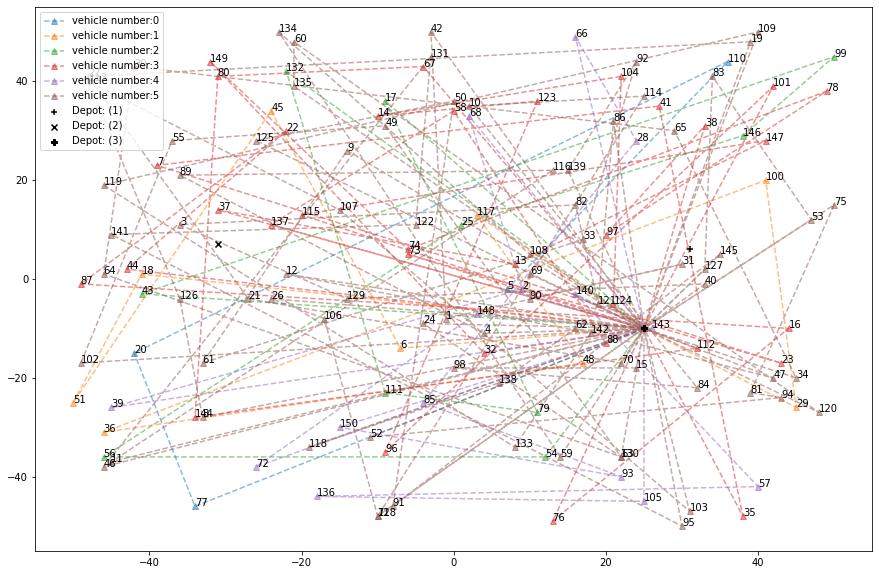

In [11]:
plot_result(p1_data, problem1_best_chromsome, DEPOT_LOCATIONS_dict)

In [9]:
chromosome = '(3)177120210105(3)|(3)217148136200129(3)118151145106(3)|(3)232211179117(3)143199246125156154(3)|(3)188158237(3)201196223114204224(3)176116187122144(3)138197178174249132(3)137113247215(3)212244180167(3)135141107123173(3)|(3)172248(3)205236157240(3)139102168(3)243250193185128166(3)|(3)202155149163(3)134165130164230124(3)186221182103229140(3)225150191245(3)195241222231146(3)104189216111(3)235160220(3)239192133161109(3)126206228(3)227183153(3)175181194152(3)171214110184198115(3)203207213226108(3)209219233242112(3)170121127119(3)169190131101142(3)208234159(3)218238162147(3)'
evaluate_distance_fitness(chromosome, 
                          DEPOT_LOCATION = DEPOT_LOCATIONS_dict['(3)'], 
                          dataset=p1_data, 
                          normalize=False)

10894

In [ ]:
evaluate_fitness_customers_count(chromosome, 
                                DEPOT_LOCATIONS_dict['(3)'], 
                                p1_data,
                                original=True)

### Problem No. 2
Problem description is written below
- There are 3 depot in the location `(31, 6)`, `(-31, 7)`, `(25, -10)`.
- There are `5` vehicles
- Maximum Capacity is `100`
- The locations of the customers and their demands are in `P1-2.txt` file
- The distance each vehicle can go is not limited.
- Two fitness functions: (1) Minimizing distance and (2) Maximizing *served customer demands* count

In [10]:
p2_data = pd.read_csv('data/P1-2.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (31, 6),
    '(2)': (-31, 7),
    '(3)': (25, -10)
}    
with open(os.path.join('results', 'problem2_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [13]:
problem2_best_chromsome, problem2_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p1_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=100, 
                max_distance=None,
                vehicle_count=5 - 1, 
                selection_method=binary_tournament,
                FITNESS_FUNCTIONS=[evaluate_distance_fitness, evaluate_fitness_customers_served_demands],
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000)


problem2_best_chromsome, problem2_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

('(3)171149228161185(3)206102(3)241112130221177104124242(3)120140166175196(3)|(3)210244192239133(3)202170215167200131(3)146217115176240(3)220150180122(3)190158117107(3)|(3)142225229218214173(3)156188182186(3)153226103139249(3)165118208116(3)141197245243128232(3)126211187135105108(3)183199109224(3)113174236164(3)213160127230(3)|(3)193233169129(3)157137191246(3)159147154(3)212207216237231(3)152134145155178(3)203101162247223(3)151179172(3)119204144(3)219121111(3)|(3)106234235250(3)123248114(3)195132222227(3)189181205143184(3)238136138194(3)110148168198(3)209125201163(3)',
 1.2474427353356583)

In [14]:
## save results
with open(os.path.join('results', 'problem2_chromosome.txt'), 'w') as file:
    file.write(problem2_best_chromsome)

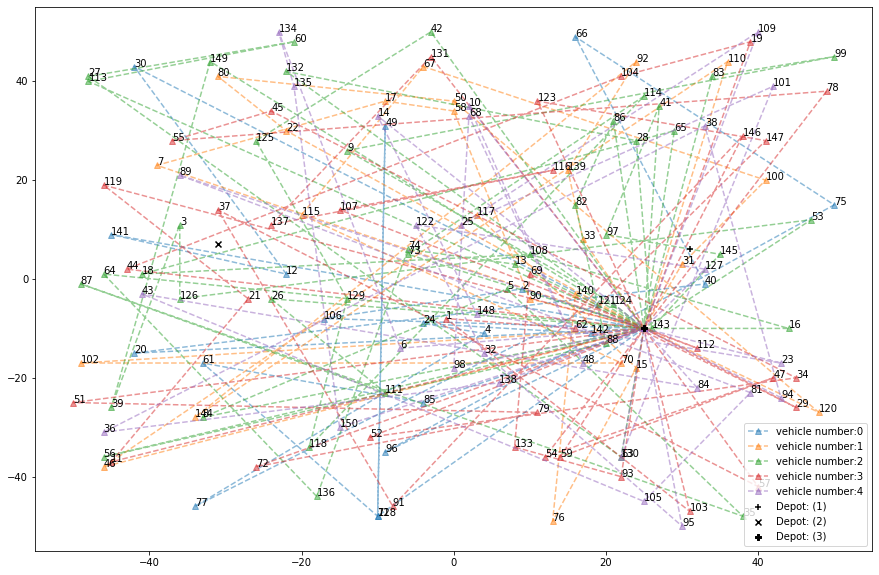

In [15]:
plot_result(p2_data, problem2_best_chromsome, DEPOT_LOCATIONS_dict)

In [12]:
chromosome = '(3)171149228161185(3)206102(3)241112130221177104124242(3)120140166175196(3)|(3)210244192239133(3)202170215167200131(3)146217115176240(3)220150180122(3)190158117107(3)|(3)142225229218214173(3)156188182186(3)153226103139249(3)165118208116(3)141197245243128232(3)126211187135105108(3)183199109224(3)113174236164(3)213160127230(3)|(3)193233169129(3)157137191246(3)159147154(3)212207216237231(3)152134145155178(3)203101162247223(3)151179172(3)119204144(3)219121111(3)|(3)106234235250(3)123248114(3)195132222227(3)189181205143184(3)238136138194(3)110148168198(3)209125201163(3)'
evaluate_distance_fitness(chromosome,
                          DEPOT_LOCATIONS_dict['(3)'],
                          p2_data,
                          normalize = False
                         )

10958

In [ ]:
evaluate_fitness_customers_served_demands(chromosome, 
                                DEPOT_LOCATIONS_dict['(3)'], 
                                p2_data,
                                original=True)

### Problem No. 3
Problem description is written below
- There are 3 depot in the location `(31, 6)`, `(-31, 7)`, `(25, -10)`.
- Maximum distace each vehicle can go is `200` Km
- The capacity is not limited for vehicles
- The locations of the customers and their demands are in `P3.txt` file
- Two fitness functions: (1) Minimizing vehicles count and (2) Maximizing *served customer demands* count

In [4]:
p3_data = pd.read_csv('data/P3.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (40, 23),
    '(2)': (0, 0),
    '(3)': (-18, -27)
}
with open(os.path.join('results', 'problem3_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [ ]:
problem3_best_chromsome, problem3_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p3_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=None, 
                max_distance=200,
                vehicle_count=None, 
                selection_method=roulette_wheel,
                FITNESS_FUNCTIONS = [evaluate_fitness_vehicle_count, evaluate_fitness_customers_served_demands],
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000,
                all_customers=False)

problem3_best_chromsome, problem3_best_chromsome_fitness

In [6]:
## save results
with open(os.path.join('results', 'problem3_chromosome.txt'), 'w') as file:
    file.write(problem3_best_chromsome)

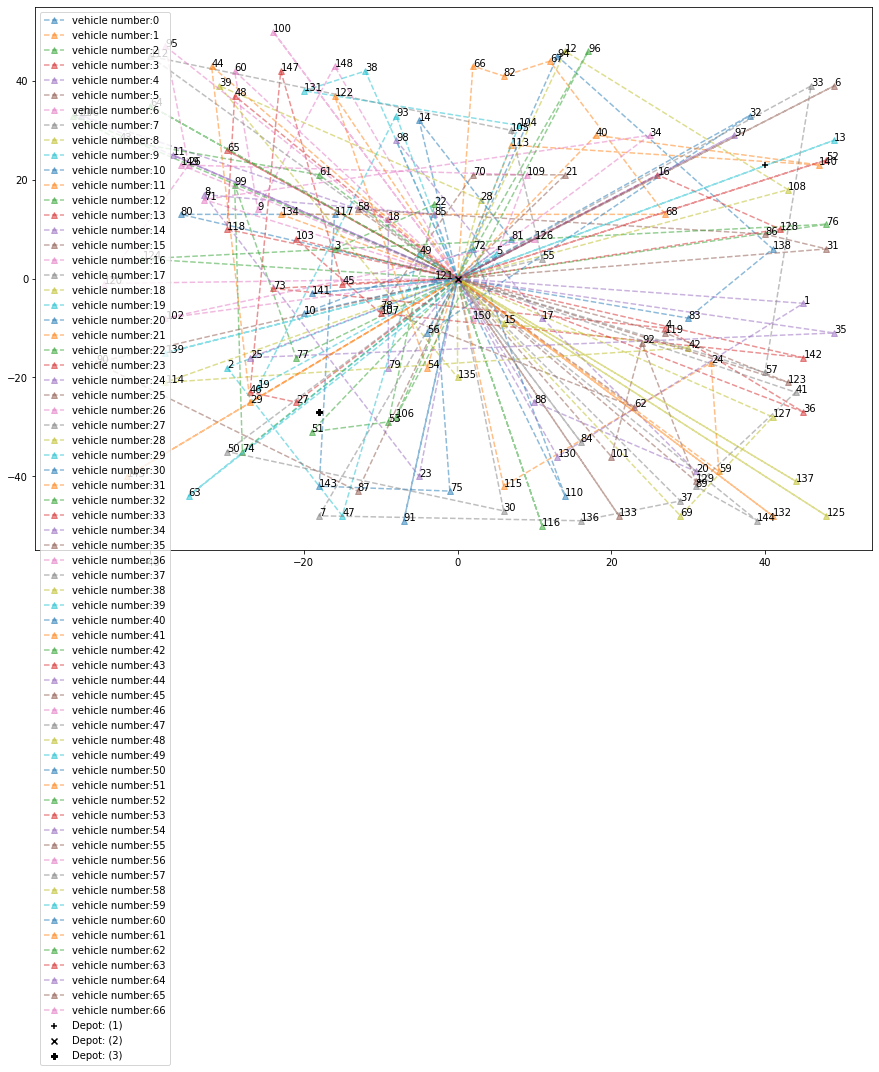

In [7]:
plot_result(p3_data, problem3_best_chromsome, DEPOT_LOCATIONS_dict)

In [14]:
chromosome = '(2)221175243217180(2)|(2)234168167182166(2)|(2)103122153151(2)|(2)127146247145(2)|(2)188120117198(2)|(2)121170178162(2)|(2)248109160(2)|(2)212205155(2)|(2)235139128(2)|(2)149147102(2)|(2)110172210(2)|(2)213240140(2)|(2)174199177(2)|(2)242207203(2)|(2)246118179(2)|(2)229192201(2)|(2)220126195(2)|(2)107236137(2)|(2)214142115(2)|(2)138231204(2)|(2)183238194(2)|(2)215124159(2)|(2)211143161(2)|(2)136104173(2)|(2)123108185(2)|(2)131186158(2)|(2)250209249(2)|(2)244189141(2)|(2)169227(2)|(2)193119(2)|(2)114181(2)|(2)129144(2)|(2)224176(2)|(2)116228(2)|(2)230101(2)|(2)223219(2)|(2)171134(2)|(2)130150(2)|(2)112208(2)|(2)163105(2)|(2)132156(2)|(2)222154(2)|(2)196206(2)|(2)218148(2)|(2)135125(2)|(2)190187(2)|(2)226202(2)|(2)157133(2)|(2)225(2)|(2)239(2)|(2)191(2)|(2)232(2)|(2)216(2)|(2)165(2)|(2)197(2)|(2)233(2)|(2)200(2)|(2)184(2)|(2)237(2)|(2)113(2)|(2)241(2)|(2)245(2)|(2)164(2)|(2)152(2)|(2)111(2)|(2)106(2)|(2)'
## vehicle count
chromosome.count('|')

66

In [ ]:
## maximizing customers demans
evaluate_fitness_customers_served_demands(chromosome, 
                                DEPOT_LOCATIONS_dict['(3)'], 
                                p3_data,
                                original=True)

## Method 2 for multi-objective handling
In this method we used to calculate the pareto-set and chosed the member of pareto set for survival.

### Problem 1

In [4]:
p1_data = pd.read_csv('data/P1-2.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (31, 6),
    '(2)': (-31, 7),
    '(3)': (25, -10)
}    
with open(os.path.join('results', 'problem1_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [6]:
problem1_best_chromsome, problem1_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p1_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=100, 
                max_distance=None,
                vehicle_count=5, 
                selection_method=roulette_wheel,
                FITNESS_FUNCTIONS=[evaluate_distance_fitness, evaluate_fitness_customers_count],
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000, 
                multi_objective_handler='nsga',
                all_customers=False)

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

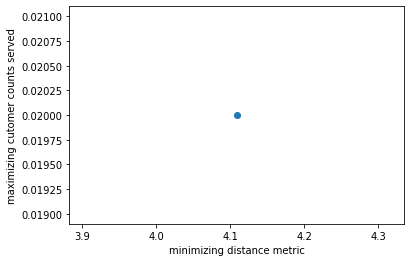

In [7]:
plt.scatter(problem1_best_chromsome_fitness[:, 0], problem1_best_chromsome_fitness[:, 1])
plt.ylabel('maximizing cutomer counts served')
plt.xlabel('minimizing distance metric')
plt.show()

In [8]:
evaluate_distance_fitness(problem1_best_chromsome[0], DEPOT_LOCATIONS_dict['(3)'], p1_data, normalize=False)

3444

In [9]:
evaluate_fitness_customers_count(problem1_best_chromsome[0], DEPOT_LOCATIONS_dict['(3)'], p1_data, normalize=False)

50.0

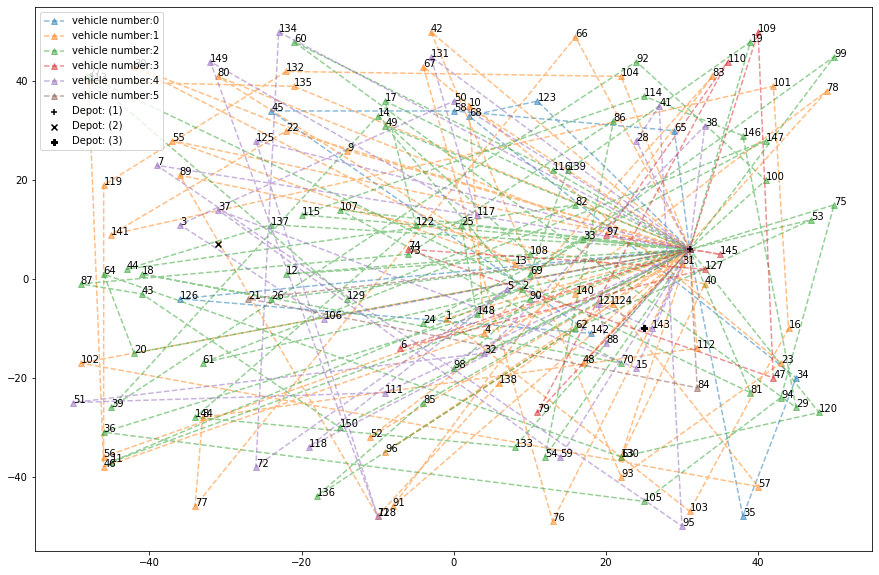

In [7]:
plot_result(p1_data, problem1_best_chromsome[0], DEPOT_LOCATIONS_dict)

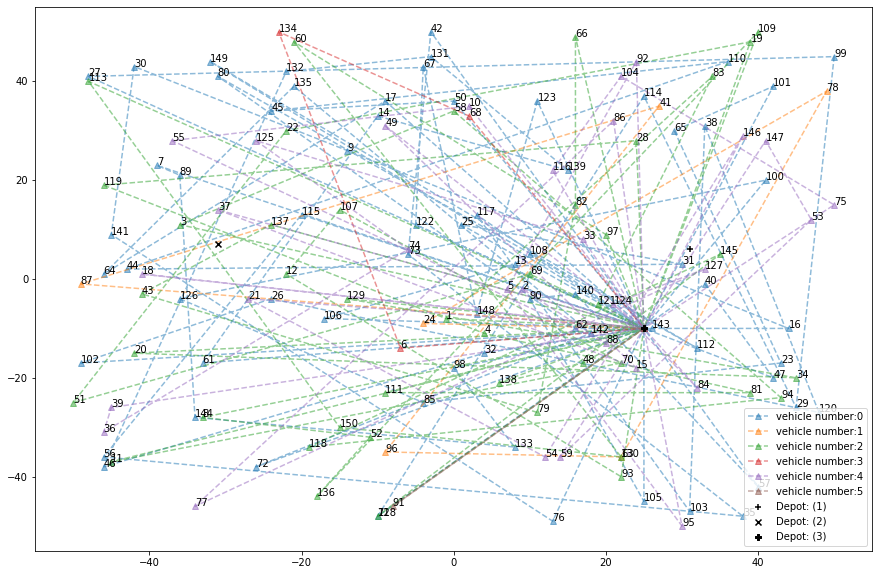

In [14]:
plot_result(p1_data, problem1_best_chromsome[1], DEPOT_LOCATIONS_dict)

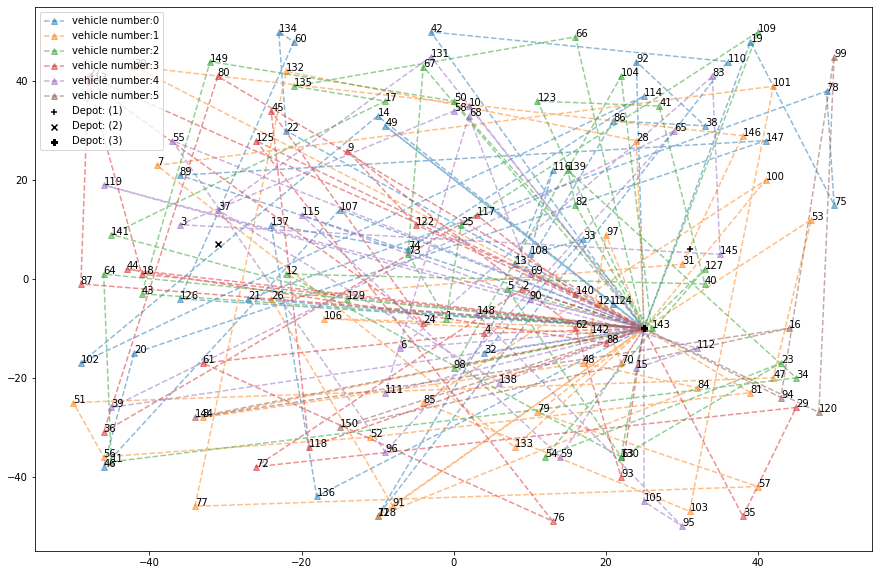

In [15]:
plot_result(p1_data, problem1_best_chromsome[2], DEPOT_LOCATIONS_dict)

### Problem 2

In [13]:
p2_data = pd.read_csv('data/P1-2.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (31, 6),
    '(2)': (-31, 7),
    '(3)': (25, -10)
}    
with open(os.path.join('results', 'problem2_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [14]:
problem2_best_chromsome, problem2_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p1_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=100, 
                max_distance=None,
                vehicle_count=5, 
                selection_method=binary_tournament,
                FITNESS_FUNCTIONS=[evaluate_distance_fitness, evaluate_fitness_customers_served_demands],
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000,
                multi_objective_handler='nsga')

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

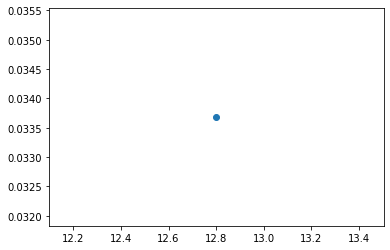

In [15]:
plt.scatter(problem2_best_chromsome_fitness[:, 0], problem2_best_chromsome_fitness[:, 1])

In [16]:
problem2_best_chromsome_fitness

array([[1.30899547e+00, 3.36813742e-04]])

In [22]:
## the distance gone
evaluate_distance_fitness(problem2_best_chromsome[0],
                          DEPOT_LOCATIONS_dict['(3)'],
                          p2_data,
                          normalize = False
                         )

10730

In [23]:
## customers served
evaluate_fitness_customers_served_demands(problem2_best_chromsome[0], 
                                DEPOT_LOCATIONS_dict['(3)'], 
                                p2_data,
                                normalize=False)

2969

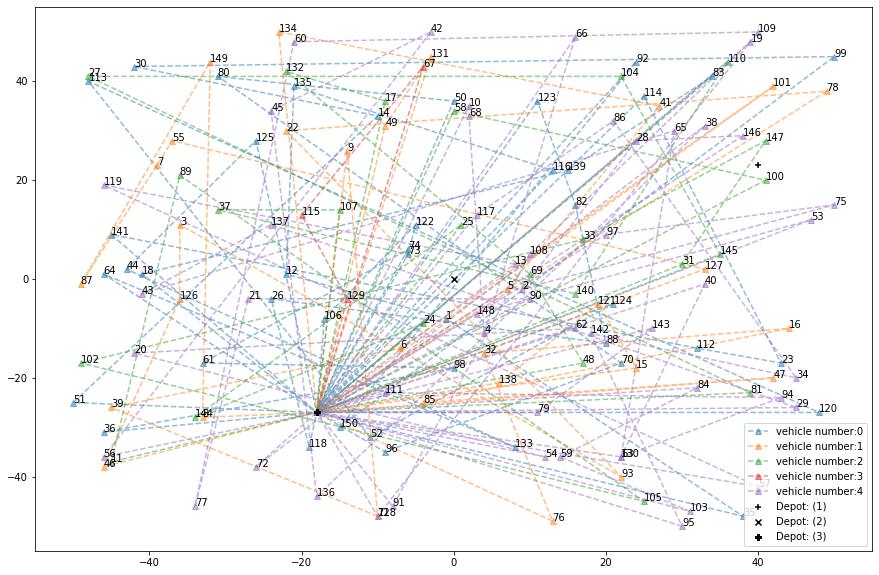

In [34]:
plot_result(p2_data, problem2_best_chromsome[0], DEPOT_LOCATIONS_dict)

### Problem 3

In [148]:
p3_data = pd.read_csv('data/P3.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (40, 23),
    '(2)': (0, 0),
    '(3)': (-18, -27)
}
with open(os.path.join('results', 'problem3_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [149]:
problem3_best_chromsome, problem3_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p3_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=None, 
                max_distance=200,
                vehicle_count=None, 
                selection_method=binary_tournament,
                FITNESS_FUNCTIONS = [evaluate_fitness_vehicle_count, evaluate_fitness_customers_served_demands],
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000,
                all_customers=False,
                multi_objective_handler='nsga')

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

In [151]:
problem3_best_chromsome_fitness

array([[3.60752778e+01, 4.87804878e-04],
       [3.20040625e+01, 4.87092060e-04]])

In [154]:
## minimizing the vehicle count
problem3_best_chromsome[0].count('|')

35

In [173]:
## maximizing customers demans
evaluate_fitness_customers_served_demands(problem3_best_chromsome[0], 
                                DEPOT_LOCATIONS_dict['(1)'], 
                                p3_data,
                                normalize=False)

2050

In [175]:
## maximizing customers demans
(problem3_best_chromsome[0], 
                                DEPOT_LOCATIONS_dict['(1)'], 
                                p3_data,
                                )

36.07527777777778

In [177]:
## maximizing customers demans
evaluate_fitness_customers_served_demands(problem3_best_chromsome[1], 
                                DEPOT_LOCATIONS_dict['(2)'], 
                                p3_data,
                                normalize=False)

2053

In [180]:
## maximizing customers demans
evaluate_fitness_vehicle_count(problem3_best_chromsome[1], 
                                DEPOT_LOCATIONS_dict['(2)'], 
                                p3_data)

32.0040625

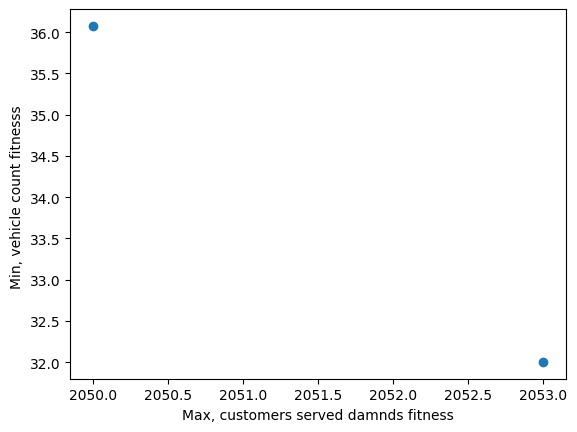

In [198]:
plt.scatter( [2050, 2053], problem3_best_chromsome_fitness[:, 0] )
plt.ylabel('Min, vehicle count fitnesss ')
plt.xlabel('Max, customers served damnds fitness')
plt.show()

In [157]:
problem3_best_chromsome

array(['(1)228232176238(1)|(1)152247158226(1)|(1)121244233(1)|(1)155114205(1)|(1)105101227(1)|(1)208154229(1)|(1)138172168(1)|(1)122219156(1)|(1)201178125(1)|(1)161142(1)|(1)117112(1)|(1)116169(1)|(1)153199(1)|(1)173195(1)|(1)198164(1)|(1)218139(1)|(1)165190(1)|(1)240216(1)|(1)221129(1)|(1)136243(1)|(1)249193(1)|(1)162107(1)|(1)128135(1)|(1)224217(1)|(1)182184(1)|(1)148119(1)|(1)204157(1)|(1)110(1)|(1)225(1)|(1)171(1)|(1)246(1)|(1)124(1)|(1)108(1)|(1)167(1)|(1)137(1)|(1)',
       '(2)187118207158128(2)|(2)177202181173(2)|(2)250194105145(2)|(2)218108205248(2)|(2)154140179(2)|(2)151107215(2)|(2)217186115(2)|(2)180174150(2)|(2)164148121(2)|(2)113132192(2)|(2)243235123(2)|(2)226195126(2)|(2)171155110(2)|(2)230131203(2)|(2)165239(2)|(2)125211(2)|(2)197133(2)|(2)236142(2)|(2)130216(2)|(2)166104(2)|(2)234116(2)|(2)200167(2)|(2)190184(2)|(2)169141(2)|(2)210206(2)|(2)233238(2)|(2)223(2)|(2)109(2)|(2)222(2)|(2)242(2)|(2)175(2)|(2)'],
      dtype='<U967')

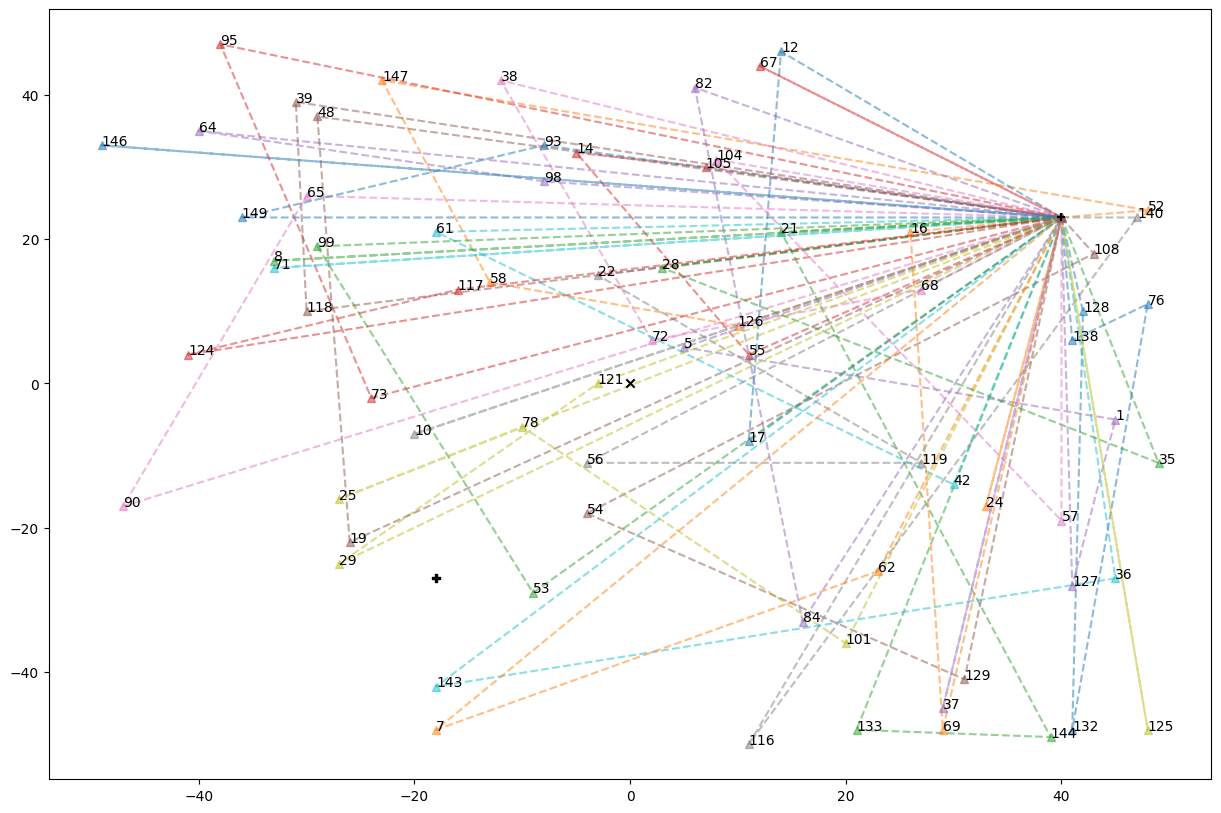

In [171]:
plot_result(p3_data, problem3_best_chromsome[0], DEPOT_LOCATIONS_dict, legend=False)

In [ ]:
plot_result(p3_data, problem3_best_chromsome[0], DEPOT_LOCATIONS_dict, legend=False)

## Pymoo NSGA-II
### Problem 1
Let's first formulate the problem
\begin{equation}
f_1(x) = \text{The total distance the vehicle gone.} \\
f_2(x) = \text{The count of customers served.}
\end{equation}

In [4]:
!python pymoo_trial.py --datasetname=data/P1-2.txt --problem_no=1 method=nsga2

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |     21 |             - |             -
     2 |      100 |     21 |  0.0165887850 |         ideal
     3 |      150 |     21 |  0.0367103622 |         ideal
     4 |      200 |     20 |  0.0061503812 |         ideal
     5 |      250 |     27 |  0.0060317730 |         ideal
     6 |      300 |     29 |  0.0288896624 |         nadir
     7 |      350 |     29 |  0.0014392217 |             f
     8 |      400 |     28 |  0.0114041340 |         ideal
     9 |      450 |     27 |  0.0100791937 |         nadir
    10 |      500 |     28 |  0.0030449038 |             f
    11 |      550 |     28 |  0.0179552950 |         nadir
    12 |      600 |     30 |  0.0014425899 |             f
    13 |      650 |     30 |  0.1017359709 |         nadir
    14 |      700 |     28 |  0.0060858207 |             f
    15 |      750 |     27 |  0.0024119841 |             f
    16 |      800 |     30 |  0.0046024340 |            

In [17]:
## after the code run, the results will be available 
problem1_depot_location_dict = {
                '(1)': (31, 6),
                '(2)': (-31, 7),
                '(3)': (25, -10)
        }   

method = 'nsga2'
problem_no = 1
problem1_fitnesses = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_fitness.csv', header=None)
problem1_pop = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_population.csv', header=None)
## hypervolume value calculated in each generation
problem1_hv = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_hv.csv', header=None)
## optimum points in each generation
problem1_opts = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_opts.csv', header=None)

In [4]:
def get_original_fitnesses(population, dataset, depot_location_dict):

    distance_fitness = []
    customer_count_fitness = []
    customers_seved_demands_fitness = []
    vehicle_count_fitness = []
    for individual in population:
        depot_symbol = find_depot_using(individual[0], depot_location_dict)
        distance = evaluate_distance_fitness(individual[0], depot_location_dict[depot_symbol], dataset, normalize=False)
        customer_count = evaluate_fitness_customers_count(individual[0], depot_location_dict[depot_symbol], dataset, normalize=False)
        customers_served = evaluate_fitness_customers_served_demands(individual[0], depot_location_dict[depot_symbol], dataset, normalize=False)
        vehicle_count = evaluate_fitness_vehicle_count(individual[0], depot_location_dict[depot_symbol], dataset)

        distance_fitness.append(distance)
        customer_count_fitness.append(customer_count)
        customers_seved_demands_fitness.append(customers_served)
        vehicle_count_fitness.append(vehicle_count)

    return distance_fitness, customer_count_fitness, customers_seved_demands_fitness, vehicle_count_fitness

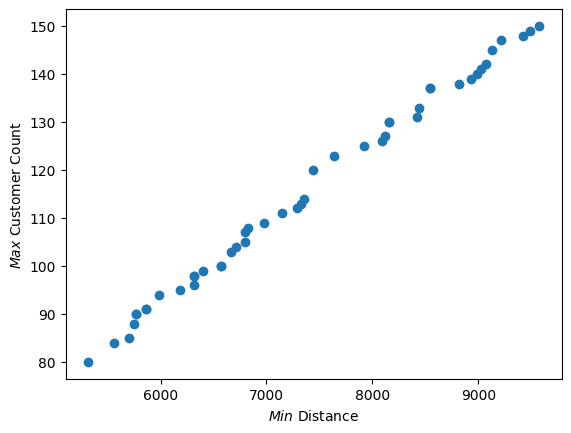

In [5]:
problem1_depot_location_dict = {
                '(1)': (31, 6),
                '(2)': (-31, 7),
                '(3)': (25, -10)
        }

p1_data = pd.read_csv('data/P1-2.txt', delimiter=' ')
distance_fitness, customer_count_fitness, _, _ = get_original_fitnesses(problem1_pop.values, p1_data, problem1_depot_location_dict)

plt.scatter(distance_fitness, customer_count_fitness)
plt.ylabel('$Max$ Customer Count')
plt.xlabel('$Min$ Distance')
plt.show()

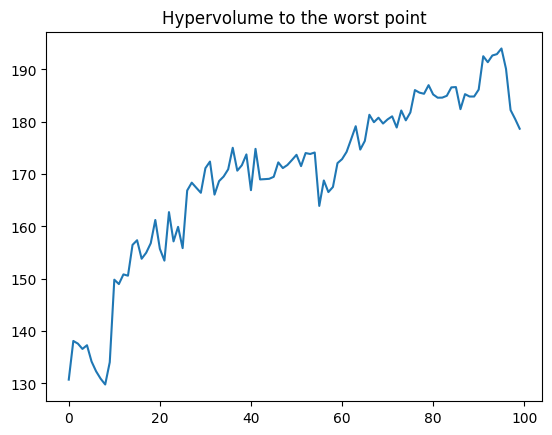

In [6]:
## based on worst point
plt.plot(problem1_hv)
plt.title('Hypervolume to the worst point')
plt.show()

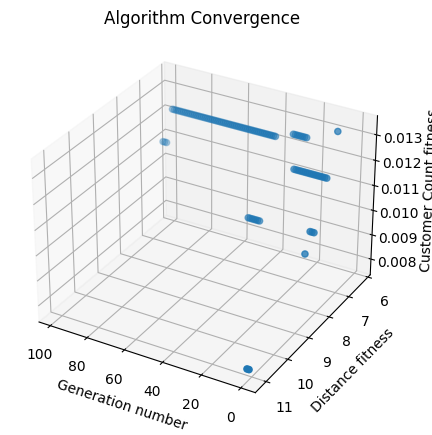

In [46]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Algorithm Convergence')
ax.scatter(problem1_opts.index.values, problem1_opts[0].values, problem1_opts[1].values)
ax.view_init(30, 120)
ax.set_xlabel('Generation number')
ax.set_ylabel('Distance fitness')
ax.set_zlabel('Customer Count fitness')
plt.show()

As we can see in the last generations the method is converged to a number of about 0.012 and 6 for distance and customer count respectively.

In [34]:
problem1_opts.head(), problem1_pop.head()

(           0         1
 0  11.127306  0.007752
 1  11.127306  0.007752
 2   8.403553  0.010000
 3   7.886586  0.010417
 4   7.886586  0.010417,
                                                    0
 0  (3)198211174223146139(3)157152186173109(3)1992...
 1  (3)175129239163101(3)144117214229(3)|(3)179146...
 2  (3)126173218134170(3)140208248143(3)227197149(...
 3  (3)156121118(3)206101170(3)102164127189155(3)1...
 4  (3)126233222116205(3)|(3)239215192102(3)164127...)

We selected the best two based on the chromosomes in pareto set 

In [43]:
problem1_pop.iloc[0].values[0], problem1_pop.iloc[15].values[0]

('(3)247219188(3)|(3)184178183180(3)149240(3)244217108171136228161208201(3)243176229226104(3)|(3)224200119103211(3)174223146139157(3)152186173109199210(3)241143213191(3)233222246141116(3)|(3)205195232239204181(3)107122207245227196(3)|(3)113163218147185236203(3)168250172187(3)114105192160137(3)125212153128(3)182130237177120134(3)126238148(3)214117242133132198166(3)221209215(3)248140115(3)170102164127189(3)155142231138249131(3)159167165(3)169202150235(3)193216230220(3)162110(3)',
 '(3)126173218134170(3)140208248143(3)227197149(3)242217215107233(3)222246141116205(3)195232239166237(3)221209133132228136115(3)192102164127(3)189155105142231(3)125138249131184172(3)|(3)185159207167114(3)250104245247165169(3)219202180150(3)|(3)236235122(3)|(3)188193216113(3)196230183220178(3)162176212110198(3)|(3)211174223146139(3)157152186109199(3)210241213191(3)')

In [109]:
distance_fitness, customer_count_fitness, _, _ = get_original_fitnesses(problem1_pop.values, p1_data, problem1_depot_location_dict)
distance_fitness[0], distance_fitness[15], customer_count_fitness[0], customer_count_fitness[15]

(5770, 6186, 90.0, 95.0)

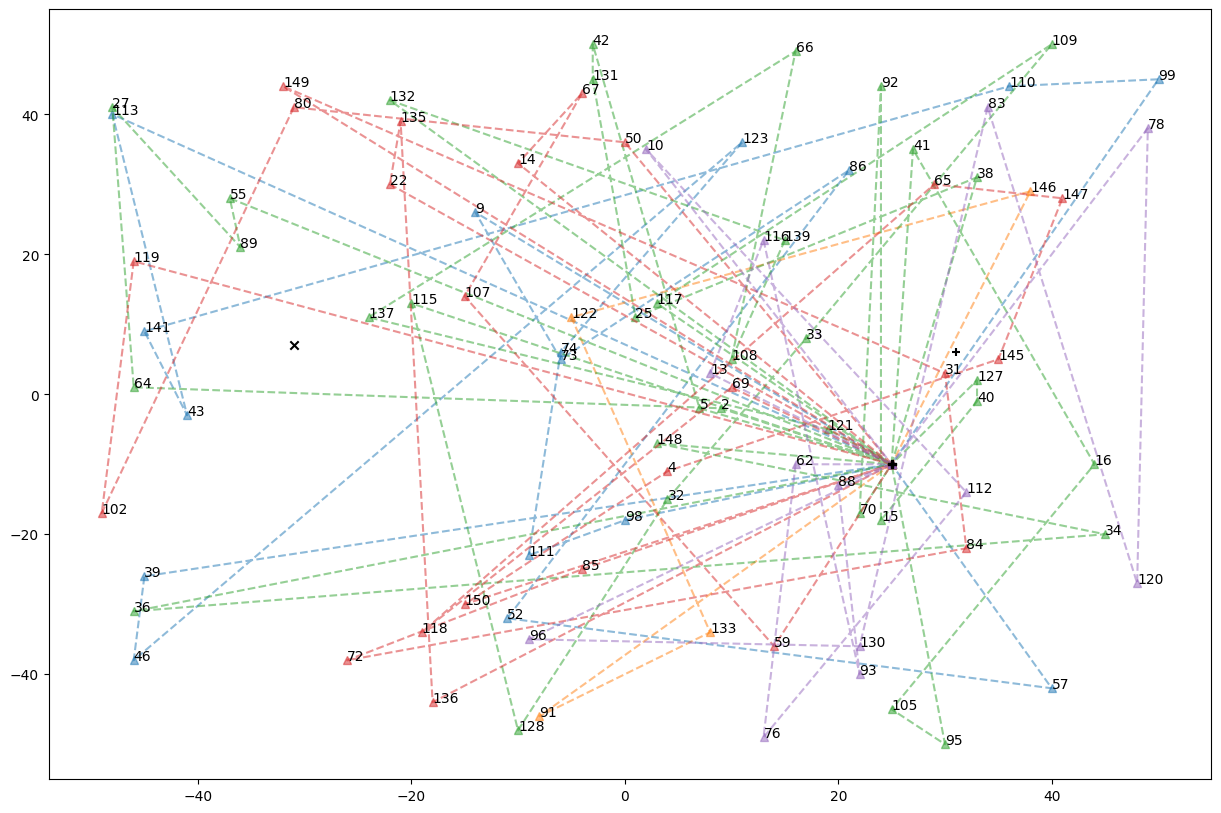

In [193]:
plot_result(p1_data, problem1_pop.iloc[0].values[0], problem1_depot_location_dict, legend=False)

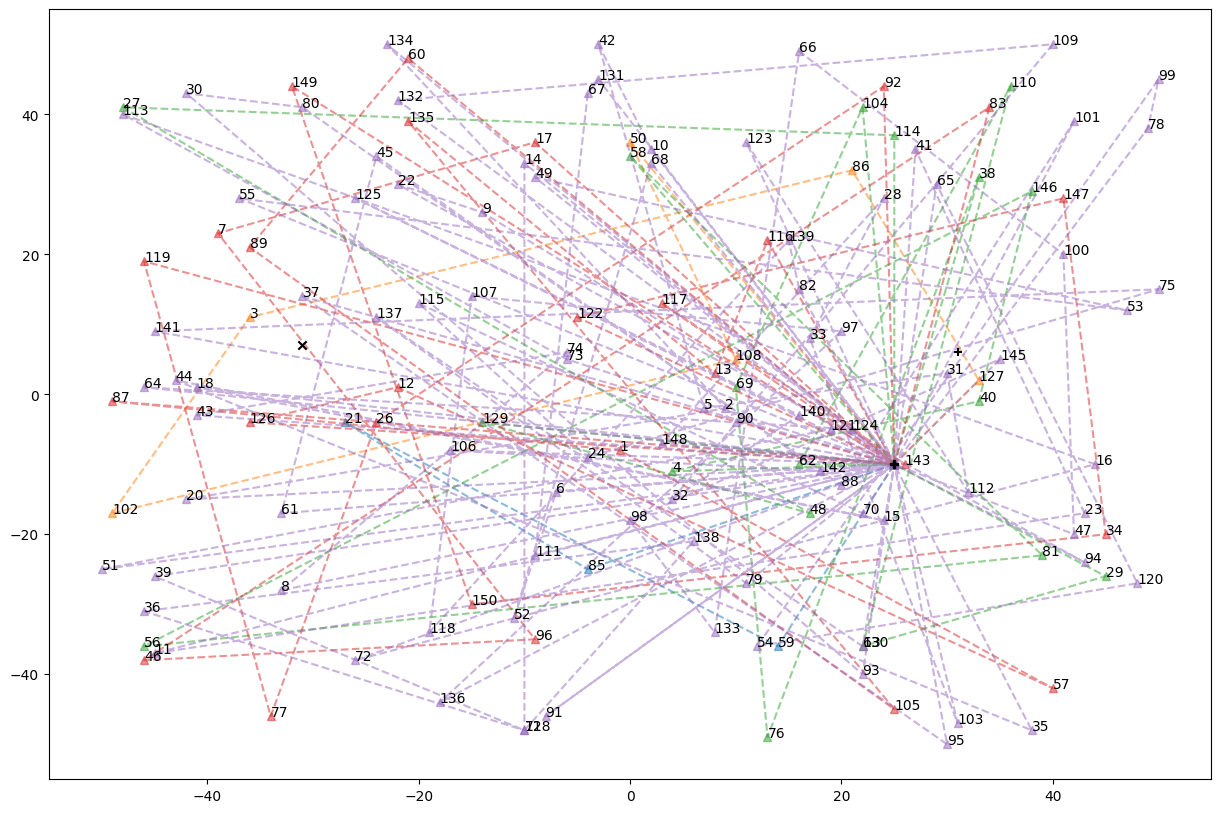

In [196]:
plot_result(p1_data, problem1_pop_moea.iloc[0].values[0], problem1_depot_location_dict, legend=False)

### Problem 2

In [10]:
!python pymoo_trial.py --datasetname=data/P1-2.txt --problem_no=2 method=nsga2

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |     19 |             - |             -
     2 |      100 |     20 |  0.0296939620 |         ideal
     3 |      150 |     25 |  0.0434215195 |         ideal
     4 |      200 |     26 |  0.1404061625 |         nadir
     5 |      250 |     24 |  0.1762767710 |         nadir
     6 |      300 |     25 |  0.0080545381 |             f
     7 |      350 |     23 |  0.0104722639 |             f
     8 |      400 |     24 |  0.0205728116 |         ideal
     9 |      450 |     24 |  0.0069727451 |             f
    10 |      500 |     25 |  0.0035844204 |             f
    11 |      550 |     24 |  0.0062885417 |             f
    12 |      600 |     28 |  0.0072202345 |             f
    13 |      650 |     26 |  0.0066407947 |             f
    14 |      700 |     28 |  0.0099061278 |             f
    15 |      750 |     30 |  0.0003642797 |             f
    16 |      800 |     33 |  0.0033825734 |            

In [18]:
## after the code run, the results will be available 
problem2_depot_location_dict = {
                '(1)': (31, 6),
                '(2)': (-31, 7),
                '(3)': (25, -10)
}

problem_no = 2
problem2_fitnesses = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method=nsga2_fitness.csv', header=None)
problem2_pop = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method=nsga2_population.csv', header=None)
problem2_hv = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method=nsga2_hv.csv', header=None)
problem2_opts = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method=nsga2_opts.csv', header=None)

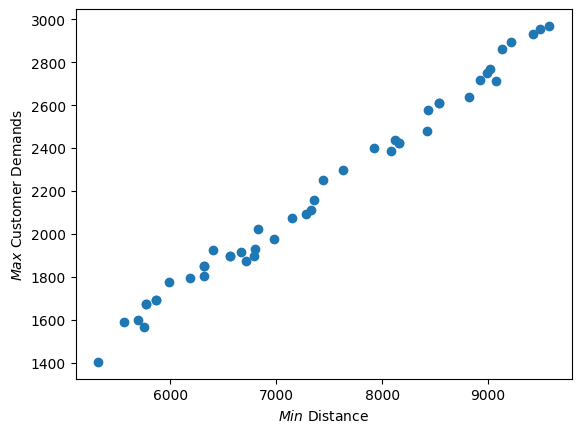

In [ ]:
p2_data = pd.read_csv('data/P1-2.txt', delimiter=' ')
distance_fitness, _, customer_demands_fitness, _ = get_original_fitnesses(problem2_pop.values, 
                                                                                            p2_data, 
                                                                                            problem2_depot_location_dict)

plt.scatter(distance_fitness, customer_demands_fitness)
plt.ylabel('$Max$ Customer Demands ')
plt.xlabel('$Min$ Distance')
plt.show()

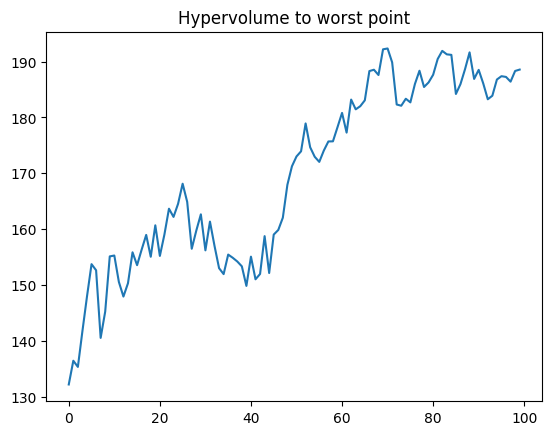

In [21]:
## based on worst point
plt.plot(problem2_hv)
plt.title('Hypervolume to worst point')
plt.show()

customer served demands is in z axis


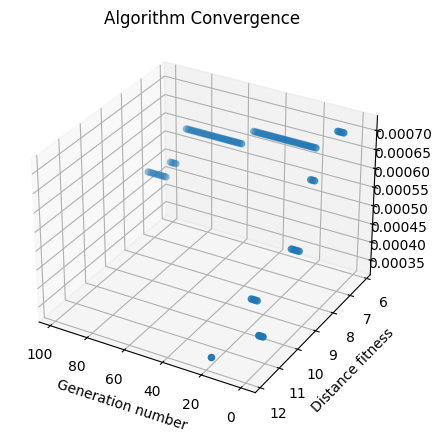

In [49]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Algorithm Convergence')
ax.scatter(problem2_opts.index.values, problem2_opts[0].values, problem2_opts[1].values)
ax.view_init(30, 120)
ax.set_xlabel('Generation number')
ax.set_ylabel('Distance fitness')
# ax.set_zlabel('distance fitness')
print('customer served demands is in z axis')
plt.show()

In [50]:
problem2_opts.head(), problem2_pop.head()

(           0         1
 0  11.127306  0.000388
 1  11.127306  0.000388
 2  11.127306  0.000388
 3   6.545206  0.000711
 4   6.545206  0.000711,
                                                    0
 0  (3)158142232235146(3)|(3)121108228191(3)122245...
 1  (3)106190191(3)120124102239(3)|(3)215114235221...
 2  (3)240195104(3)118103189113131(3)2471781831142...
 3  (3)157129186179(3)169107142232231(3)|(3)172237...
 4  (3)158142232235146(3)121108228191(3)|(3)122245...)

In [190]:
problem2_pop.iloc[5].values[0], '',problem2_pop.iloc[20].values[0]

('(3)221124152173109(3)143213222141205(3)|(3)123168126(3)217137119212(3)148194128201(3)206101(3)|(3)149145229(3)|(3)153135224147193132(3)200181227115192246(3)176185199226162(3)154120240(3)195104(3)118103189113131(3)247178183114223210(3)188138249150(3)|(3)215202136127155(3)105230196167110(3)220184163(3)158174125156187245(3)102216219(3)211165159198(3)164142250208133169(3)140170218139157186(3)116172180146122241(3)191236233(3)232108228134(3)248182209106(3)190207239166225(3)129242238197(3)179231107237(3)235121(3)',
 '',
 '(3)173109143213224(3)|(3)206212(3)225198168217(3)194115176222(3)141116123(3)126137192246185174(3)199195104189113131(3)247178183114223180241(3)237172210232146(3)191122119(3)148128201101(3)149145229(3)153135147159(3)165193132200181227140(3)170157226162(3)154240(3)118184(3)|(3)197156163179(3)231107187158142(3)121108228171234130(3)|(3)244214204160112203(3)161151111144177243(3)215202136127155(3)105230196167110(3)220125245102(3)235164250218(3)|(3)219211(3)238129208(3)13415223623

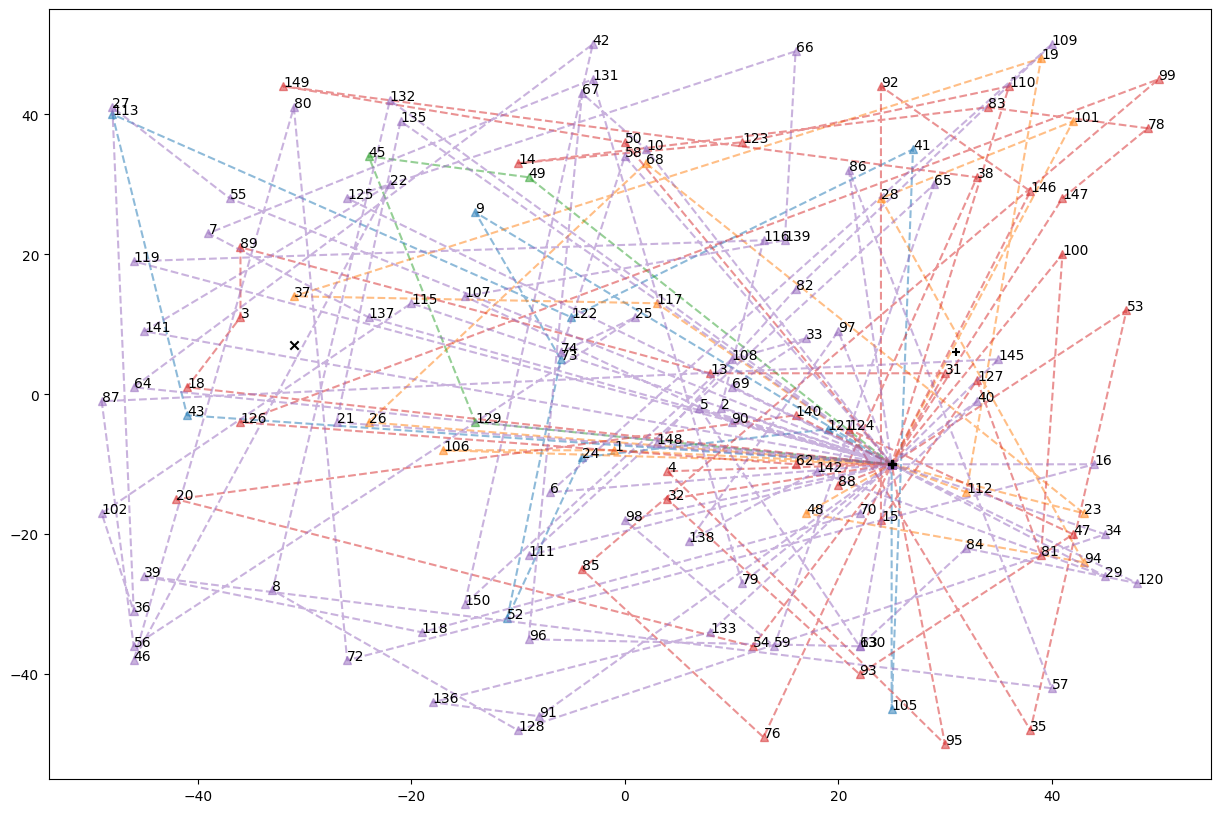

In [191]:
plot_result(p2_data, problem2_pop.iloc[5].values[0], problem2_depot_location_dict, legend=False)

### Problem 3

In [22]:
!python pymoo_trial.py --datasetname=data/P3.txt --problem_no=3 method=nsga2

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |     12 |             - |             -
     2 |      100 |      6 |  2.0326461642 |         ideal
     3 |      150 |      7 |  0.0420097123 |         ideal
     4 |      200 |      5 |  1.5396110057 |         nadir
     5 |      250 |      7 |  0.0258701157 |             f
     6 |      300 |      8 |  0.1669686251 |         nadir
     7 |      350 |      8 |  0.2369010778 |         nadir
     8 |      400 |      8 |  0.000000E+00 |             f
     9 |      450 |      9 |  0.0314210429 |             f
    10 |      500 |      9 |  0.0049588287 |             f
    11 |      550 |     10 |  0.0175044297 |             f
    12 |      600 |      9 |  0.0113768389 |             f
    13 |      650 |      9 |  0.0113842495 |             f
    14 |      700 |      9 |  0.0441225627 |         nadir
    15 |      750 |      9 |  0.000000E+00 |             f
    16 |      800 |     10 |  0.0701085013 |         nad

In [23]:
## after the code run, the results will be available 
problem3_depot_location_dict = {
                '(1)': (40, 23),
                '(2)': (0, 0),
                '(3)': (-18, -27)
        }  

problem_no = 3
problem3_fitnesses = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method=nsga2_fitness.csv', header=None)
problem3_pop = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method=nsga2_population.csv', header=None)
problem3_hv = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method=nsga2_hv.csv', header=None)
problem3_opts = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method=nsga2_opts.csv', header=None)
p3_data = pd.read_csv('data/P3.txt', delimiter=' ')

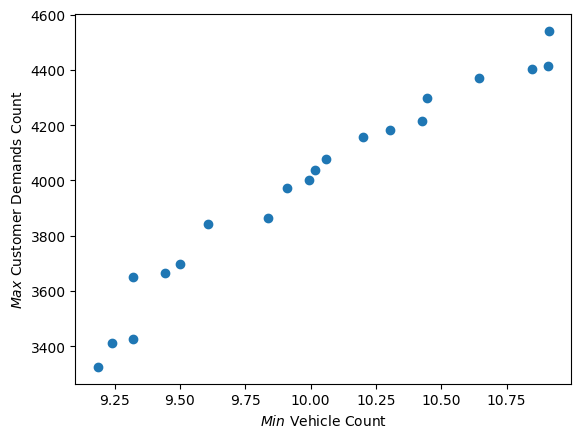

In [25]:
_, _, customer_demands_fitness, vehicle_count_fitness = get_original_fitnesses(problem3_pop.values, 
                                                                                            p3_data, 
                                                                                            problem3_depot_location_dict)

plt.scatter(vehicle_count_fitness , customer_demands_fitness)
plt.ylabel('$Max$ Customer Demands Count')
plt.xlabel('$Min$ Vehicle Count')
plt.show()

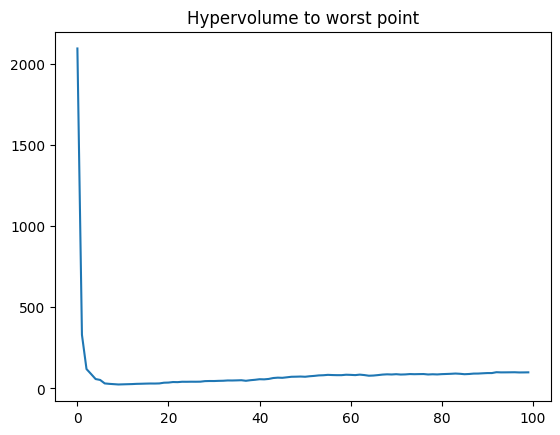

In [26]:
## based on worst point
plt.plot(problem3_hv)
plt.title('Hypervolume to worst point')
plt.show()

z axis is Customer served demands Count fitness
y axis is with distance penalty


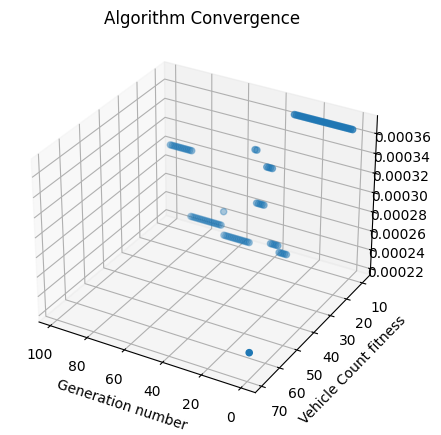

In [59]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Algorithm Convergence')
ax.scatter(problem3_opts.index.values, problem3_opts[0].values, problem3_opts[1].values)
ax.view_init(30, 120)
ax.set_xlabel('Generation number')
ax.set_ylabel('Vehicle Count fitness')
# ax.set_zlabel('Customer served demands Count fitness')
print('z axis is Customer served demands Count fitness')
print('y axis is with distance penalty')
plt.show()

In [60]:
problem3_opts.head(), problem3_pop.head()

(           0         1
 0  69.027971  0.000241
 1   9.961667  0.000367
 2   9.961667  0.000367
 3   9.961667  0.000367
 4   9.961667  0.000367,
                                                    0
 0  (1)2111122341141671981561471351822101461991602...
 1  (3)2172462121962052111122341931261481211522251...
 2  (1)2341082181191602001641021232151301461991141...
 3  (1)2111122341141671981561471351822101461991602...
 4  (2)1632221312271411891201681791501241471872101...)

In [132]:
problem3_opts.head()

0         1
0  69.027971  0.000241
1   9.961667  0.000367
2   9.961667  0.000367
3   9.961667  0.000367
4   9.961667  0.000367

In [141]:
problem3_pop.iloc[4].values[0], '' ,problem3_pop.iloc[16].values[0]

('(2)163222131227141189120168179150124147187210195111202249180230232134113238186116185246212196205193211112135245154177110125171220109224149159216115217165126148121152225229138139161128221191184242192122209157244223208203143105247106(2)|(2)234108218119160200164102123215130146199114167198156175151129153235188206197170207158250204(2)|(2)178241239142117104101183243173145(2)|(2)190248166213228236136169137174155(2)|(2)132182118226(2)|(2)',
 '',
 '(1)225242223157229226176192190135171220109224149132124159216115217165166213248126148121152189120236169137174179150191184131141163235188206207241239142117104101234108218119160200164102123215130183209197170195111202249180230232134113238186116185246212196205193243203247155211112114167198156147173122208(1)|(1)244245154177110118145158250178187129153182210146199175151125222228105106(1)|(1)227136103168161138128221172194144(1)|(1)143139204(1)|(1)')

In [143]:
_, _, customer_demands_fitness, vehicle_count_fitness = get_original_fitnesses(problem3_pop.values, 
                                                                                            p3_data, 
                                                                                            problem3_depot_location_dict)
vehicle_count_fitness[4], vehicle_count_fitness[16], customer_demands_fitness[4], customer_demands_fitness[16]

(10.016666666666666, 10.303999999999998, 4037, 4182)

## Pymoo MOEA/D
### Problem 1

In [66]:
!python pymoo_trial.py --datasetname=data/P1-2.txt --problem_no=1 method=moea

MOEAD algorithm is running!
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       11 |      8 |             - |             -
     2 |       22 |     11 |  0.0181135981 |         ideal
     3 |       33 |     11 |  0.0575522669 |         ideal
     4 |       44 |     11 |  0.0165489850 |             f
     5 |       55 |     11 |  0.0223785166 |         ideal
     6 |       66 |     11 |  0.000000E+00 |             f
     7 |       77 |     11 |  0.000000E+00 |             f
     8 |       88 |     11 |  0.000000E+00 |             f
     9 |       99 |     11 |  0.000000E+00 |             f
    10 |      110 |     11 |  0.0071942446 |         ideal
    11 |      121 |     11 |  0.000000E+00 |             f
    12 |      132 |     11 |  0.000000E+00 |             f
    13 |      143 |     11 |  0.000000E+00 |             f
    14 |      154 |     11 |  0.0052785924 |             f
    15 |      165 |     11 |  0.0394736842 |         ideal
    16 |      176 |     11 |

In [68]:
## after the code run, the results will be available 
problem1_depot_location_dict = {
                '(1)': (40, 23),
                '(2)': (0, 0),
                '(3)': (-18, -27)
        }  

method = 'moea'
problem_no = 1
problem1_fitnesses_moea = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_fitness.csv', header=None)
problem1_pop_moea = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_population.csv', header=None)
problem1_hv_moea = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_hv.csv', header=None)
problem1_opts_moea = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_opts.csv', header=None)

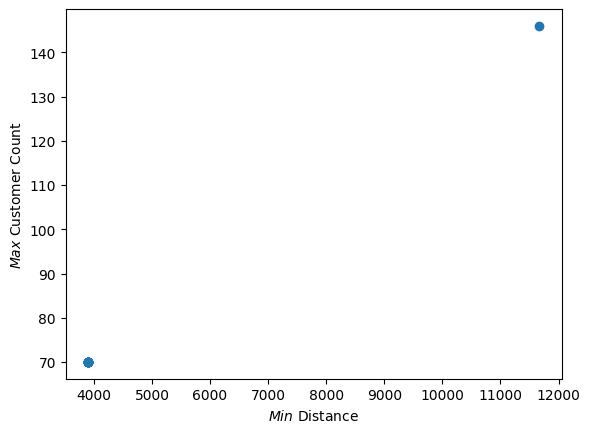

In [69]:
problem1_depot_location_dict = {
                '(1)': (31, 6),
                '(2)': (-31, 7),
                '(3)': (25, -10)
        }

p1_data = pd.read_csv('data/P1-2.txt', delimiter=' ')
distance_fitness, customer_count_fitness, _, _ = get_original_fitnesses(problem1_pop_moea.values, p1_data, problem1_depot_location_dict)

plt.scatter(distance_fitness, customer_count_fitness)
plt.ylabel('$Max$ Customer Count')
plt.xlabel('$Min$ Distance')
plt.show()

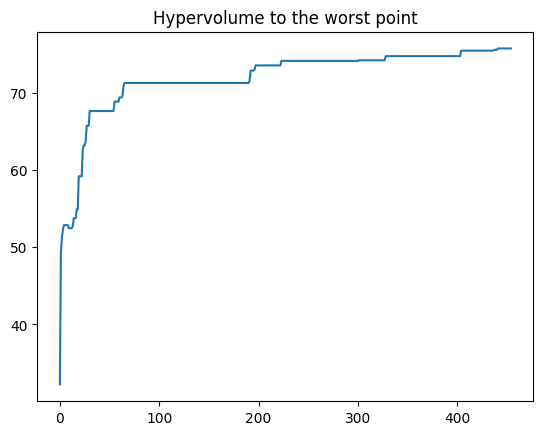

In [75]:
## based on worst point
plt.plot(problem1_hv_moea)
plt.title('Hypervolume to the worst point')
plt.show()

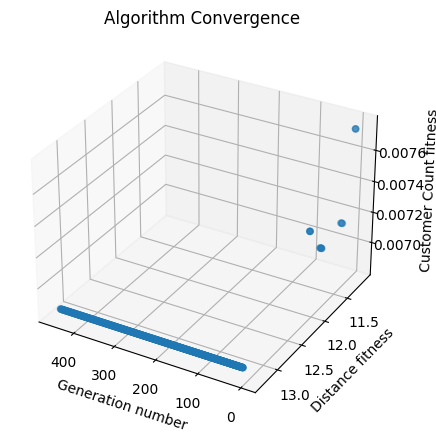

In [76]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Algorithm Convergence')
ax.scatter(problem1_opts_moea.index.values, problem1_opts_moea[0].values, problem1_opts_moea[1].values)
ax.view_init(30, 120)
ax.set_xlabel('Generation number')
ax.set_ylabel('Distance fitness')
ax.set_zlabel('Customer Count fitness')
plt.show()

In [77]:
problem1_opts_moea.head(), problem1_pop_moea.head()

(           0         1
 0  11.127306  0.007752
 1  11.127306  0.007752
 2  12.051924  0.007353
 3  12.051924  0.007353
 4  11.311774  0.007194,
                                                    0
 0  (3)185121159(3)|(3)150208202103186227(3)|(3)22...
 1  (3)185121159(3)|(3)216235160112177250(3)|(3)24...
 2  (3)185121159(3)|(3)216235160112177250(3)|(3)24...
 3  (3)185121159(3)|(3)216235160112177250(3)|(3)24...
 4  (3)185121159(3)|(3)216235160112177250(3)|(3)24...)

In [80]:
problem1_pop_moea.iloc[2].values[0], '', problem1_pop_moea.iloc[8].values[0]

('(3)185121159(3)|(3)216235160112177250(3)|(3)243181128117104129(3)219222183163(3)202156101237179(3)150249103146187162(3)|(3)169132226126217(3)158214204138(3)248208133(3)229227246210186(3)192230205148127(3)|(3)157176196134(3)140247178199165164107(3)203113245189228207102(3)',
 '',
 '(3)185121159(3)|(3)216235160112177250(3)|(3)243181128117104129(3)219222183163(3)202156101237179(3)150249103146187162(3)|(3)169132226126217(3)158214204138(3)248208133(3)229227246210186(3)192230205148127(3)|(3)157176196134(3)140247178199165164107(3)203113245189228207102(3)')

In [106]:
distance_fitness, customer_count_fitness, _, _ = get_original_fitnesses(problem1_pop_moea.values, p1_data, problem1_depot_location_dict)
distance_fitness[2], distance_fitness[8], customer_count_fitness[2], customer_count_fitness[8]

(3904, 3904, 70.0, 70.0)

### Problem 1 MOEA/D comparison with NGSA-II

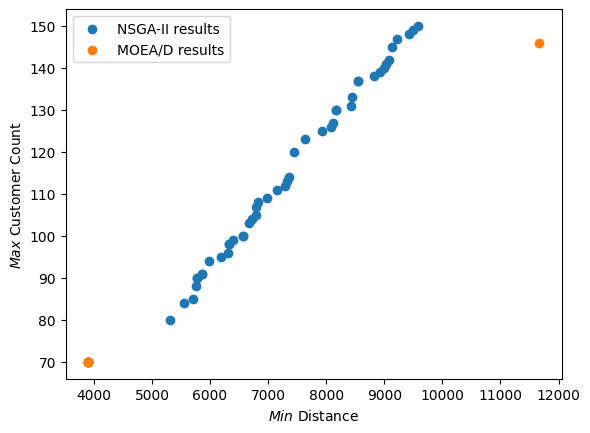

In [100]:
distance_fitness, customer_count_fitness, _, _ = get_original_fitnesses(problem1_pop.values, p1_data, problem1_depot_location_dict)
distance_fitness_moea, customer_count_fitness_moea, _, _ = get_original_fitnesses(problem1_pop_moea.values, p1_data, problem1_depot_location_dict)

plt.scatter(distance_fitness, customer_count_fitness, label='NSGA-II results')
plt.scatter(distance_fitness_moea, customer_count_fitness_moea, label='MOEA/D results')
plt.ylabel('$Max$ Customer Count')
plt.xlabel('$Min$ Distance')
plt.legend()
plt.show()

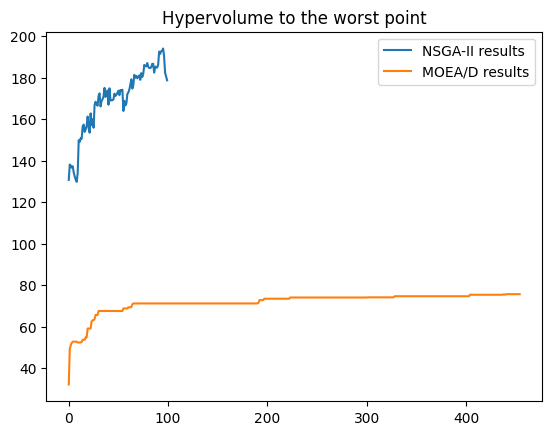

In [116]:
## based on worst point
plt.plot(problem1_hv, label='NSGA-II results')
plt.plot(problem1_hv_moea, label='MOEA/D results')
plt.title('Hypervolume to the worst point')
plt.legend()
plt.show()

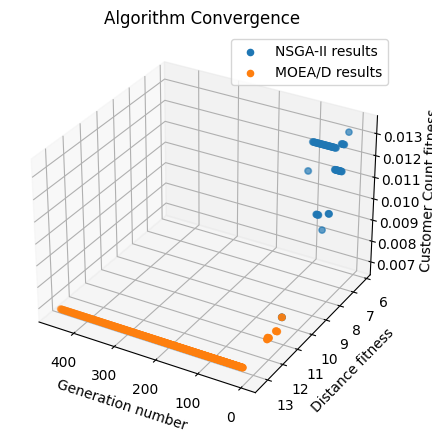

In [104]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Algorithm Convergence')
ax.scatter(problem1_opts.index.values, problem1_opts[0].values, problem1_opts[1].values, label='NSGA-II results')
ax.scatter(problem1_opts_moea.index.values, problem1_opts_moea[0].values, problem1_opts_moea[1].values, label='MOEA/D results')
ax.view_init(30, 120)
ax.set_xlabel('Generation number')
ax.set_ylabel('Distance fitness')
ax.set_zlabel('Customer Count fitness')
plt.legend()
plt.show()

### Problem 2

In [81]:
!python pymoo_trial.py --datasetname=data/P1-2.txt --problem_no=2 method=moea

MOEAD algorithm is running!
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       11 |     10 |             - |             -
     2 |       22 |     11 |  0.0123256645 |         ideal
     3 |       33 |     11 |  0.0347364922 |         ideal
     4 |       44 |     11 |  0.0165489850 |             f
     5 |       55 |     11 |  0.0146385732 |         ideal
     6 |       66 |     11 |  0.000000E+00 |             f
     7 |       77 |     11 |  0.000000E+00 |             f
     8 |       88 |     11 |  0.000000E+00 |             f
     9 |       99 |     11 |  0.000000E+00 |             f
    10 |      110 |     11 |  0.0026250186 |         ideal
    11 |      121 |     11 |  0.000000E+00 |             f
    12 |      132 |     11 |  0.000000E+00 |             f
    13 |      143 |     11 |  0.000000E+00 |             f
    14 |      154 |     11 |  0.0052785924 |             f
    15 |      165 |     11 |  0.0313417757 |         ideal
    16 |      176 |     11 |

In [83]:
## after the code run, the results will be available 
problem2_depot_location_dict = {
                '(1)': (31, 6),
                '(2)': (-31, 7),
                '(3)': (25, -10)
}

method = 'moea'
problem_no = 2
problem2_fitnesses_moea = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_fitness.csv', header=None)
problem2_pop_moea = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_population.csv', header=None)
problem2_hv_moea = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_hv.csv', header=None)
problem2_opts_moea = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_opts.csv', header=None)

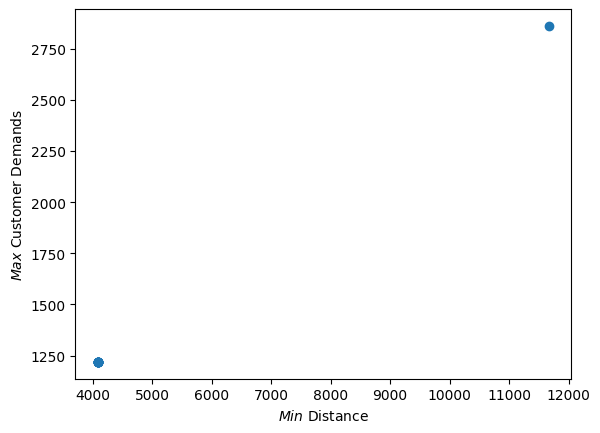

In [84]:
p2_data = pd.read_csv('data/P1-2.txt', delimiter=' ')
distance_fitness, _, customer_demands_fitness, _ = get_original_fitnesses(problem2_pop_moea.values, 
                                                                                            p2_data, 
                                                                                            problem2_depot_location_dict)

plt.scatter(distance_fitness, customer_demands_fitness)
plt.ylabel('$Max$ Customer Demands ')
plt.xlabel('$Min$ Distance')
plt.show()

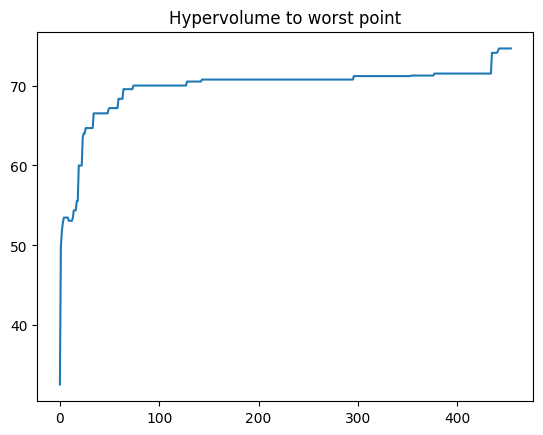

In [85]:
## based on worst point
plt.plot(problem2_hv_moea)
plt.title('Hypervolume to worst point')
plt.show()

customer served demands is in z axis


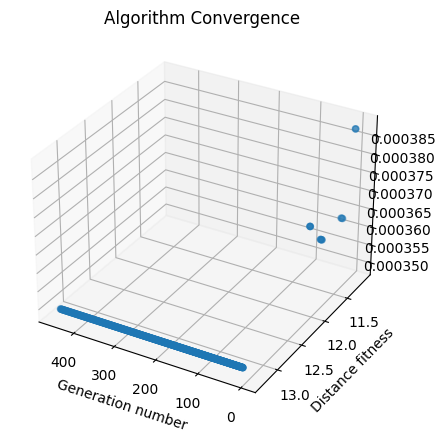

In [86]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Algorithm Convergence')
ax.scatter(problem2_opts_moea.index.values, problem2_opts_moea[0].values, problem2_opts_moea[1].values)
ax.view_init(30, 120)
ax.set_xlabel('Generation number')
ax.set_ylabel('Distance fitness')
# ax.set_zlabel('distance fitness')
print('customer served demands is in z axis')
plt.show()

In [87]:
problem2_opts_moea.head(), problem2_pop_moea.head()

(           0         1
 0  11.127306  0.000388
 1  11.127306  0.000388
 2  12.051924  0.000372
 3  12.051924  0.000372
 4  11.311774  0.000365,
                                                    0
 0  (3)185121159(3)|(3)150208202103186227(3)|(3)22...
 1  (3)159185121(3)150208202103186148(3)1871071562...
 2  (3)159185121(3)150208202103186148(3)1871071562...
 3  (3)159185121(3)150208202103186148(3)1871071562...
 4  (3)159185121(3)150208202103186148(3)1871071562...)

In [89]:
problem2_pop_moea.iloc[5].values[0], '',problem2_pop_moea.iloc[10].values[0]

('(3)159185121(3)150208202103186148(3)187107156229162(3)183243217158129246(3)104248203(3)227101222250(3)204237178126181(3)|(3)127219164226(3)|(3)210247179163230(3)|(3)205214199117160235189(3)245196133138169228176(3)157134177207112113165(3)132146249192128216140(3)|(3)102(3)',
 '',
 '(3)159185121(3)150208202103186148(3)187107156229162(3)183243217158129246(3)104248203(3)227101222250(3)204237178126181(3)|(3)127219164226(3)|(3)210247179163230(3)|(3)205214199117160235189(3)245196133138169228176(3)157134177207112113165(3)132146249192128216140(3)|(3)102(3)')

In [119]:
distance_fitness_moea, _, customer_demands_fitness_moea, _ = get_original_fitnesses(problem2_pop_moea.values, 
                                                                                            p2_data, 
                                                                                            problem2_depot_location_dict)
distance_fitness_moea[5], distance_fitness_moea[10], customer_demands_fitness_moea[5], customer_demands_fitness_moea[10]

(4090, 4090, 1219, 1219)

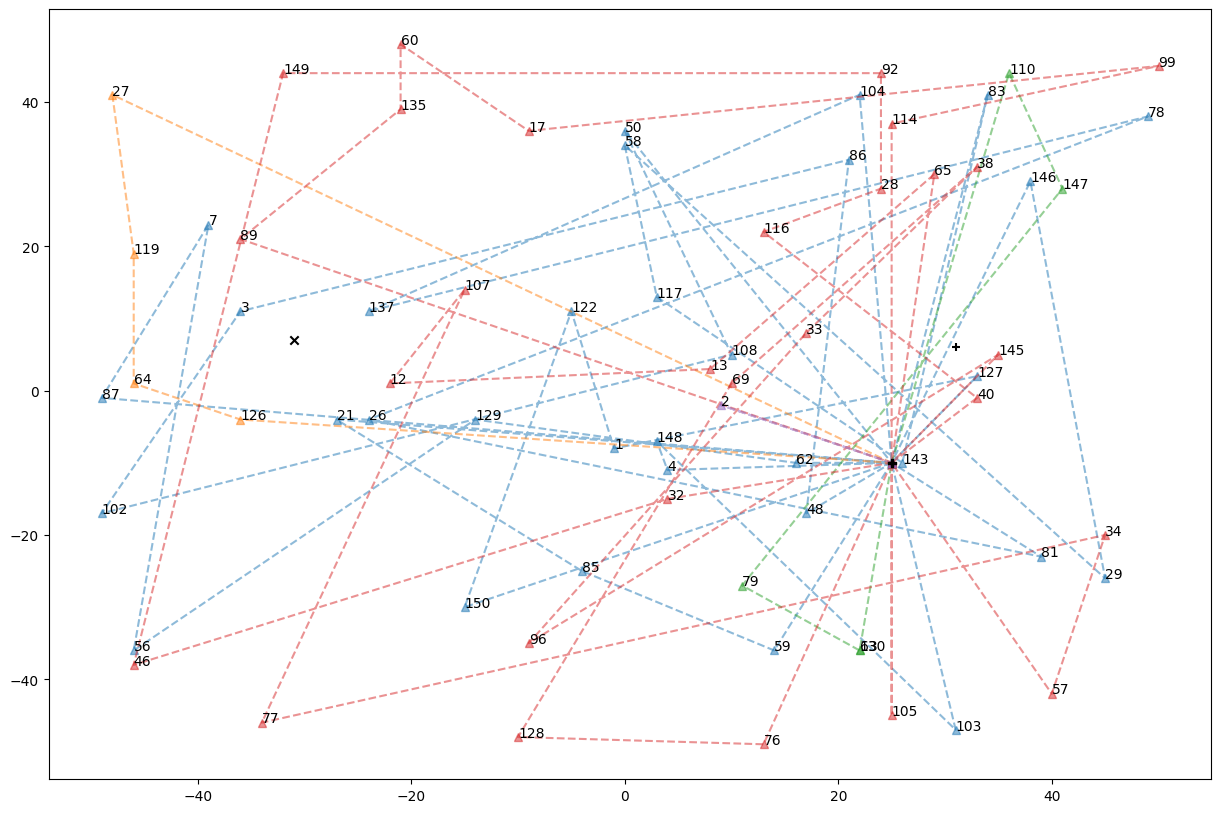

In [189]:
plot_result(p2_data, problem2_pop_moea.iloc[5].values[0], problem2_depot_location_dict, legend=False)

### Problem 2 NSGA-II and MOEA/D comparison

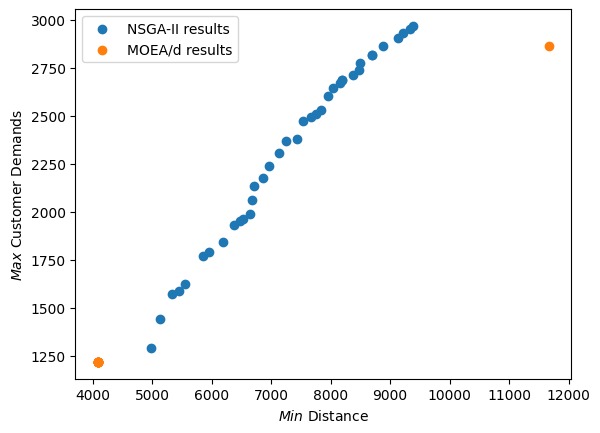

In [111]:
distance_fitness, _, customer_demands_fitness, _ = get_original_fitnesses(problem2_pop.values, 
                                                                                            p2_data, 
                                                                                            problem2_depot_location_dict)
distance_fitness_moea, _, customer_demands_fitness_moea, _ = get_original_fitnesses(problem2_pop_moea.values, 
                                                                                            p2_data, 
                                                                                            problem2_depot_location_dict)
plt.scatter(distance_fitness, customer_demands_fitness,  label='NSGA-II results')
plt.scatter(distance_fitness_moea, customer_demands_fitness_moea,  label='MOEA/d results')
plt.legend()
plt.ylabel('$Max$ Customer Demands ')
plt.xlabel('$Min$ Distance')
plt.show()

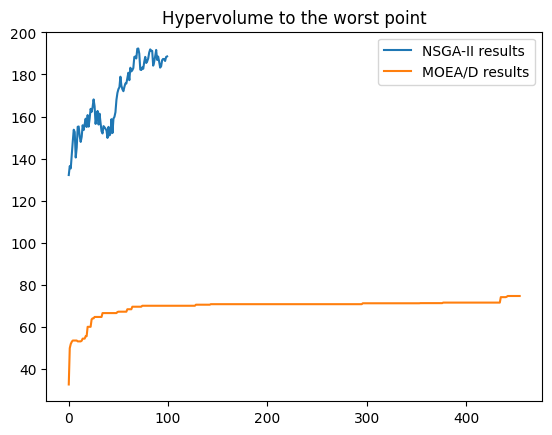

In [115]:
## based on worst point
plt.plot(problem2_hv, label='NSGA-II results')
plt.plot(problem2_hv_moea, label='MOEA/D results')
plt.title('Hypervolume to the worst point')
plt.legend()
plt.show()

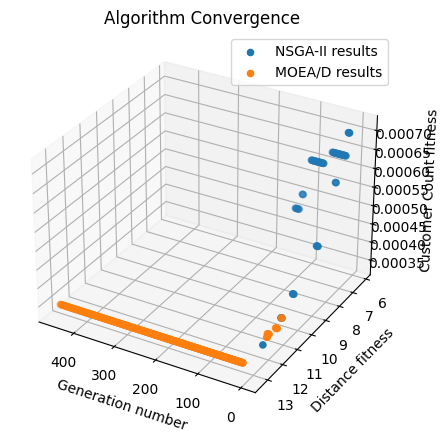

In [117]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Algorithm Convergence')
ax.scatter(problem2_opts.index.values, problem2_opts[0].values, problem2_opts[1].values, label='NSGA-II results')
ax.scatter(problem2_opts_moea.index.values, problem2_opts_moea[0].values, problem2_opts_moea[1].values, label='MOEA/D results')
ax.view_init(30, 120)
ax.set_xlabel('Generation number')
ax.set_ylabel('Distance fitness')
ax.set_zlabel('Customer Count fitness')
plt.legend()
plt.show()

### Problem 3

In [90]:
!python pymoo_trial.py --datasetname=data/P3.txt --problem_no=3 method=moea

MOEAD algorithm is running!
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       11 |      6 |             - |             -
     2 |       22 |     10 |  2.382943E+01 |         ideal
     3 |       33 |     10 |  0.000000E+00 |             f
     4 |       44 |     10 |  0.000000E+00 |             f
     5 |       55 |     10 |  0.000000E+00 |             f
     6 |       66 |     10 |  0.000000E+00 |             f
     7 |       77 |     10 |  0.000000E+00 |             f
     8 |       88 |     10 |  0.000000E+00 |             f
     9 |       99 |     10 |  0.000000E+00 |             f
    10 |      110 |     10 |  0.000000E+00 |             f
    11 |      121 |     10 |  0.2557142857 |         ideal
    12 |      132 |     10 |  0.000000E+00 |             f
    13 |      143 |     10 |  0.000000E+00 |             f
    14 |      154 |     10 |  0.000000E+00 |             f
    15 |      165 |     10 |  0.000000E+00 |             f
    16 |      176 |     10 |

In [91]:
## after the code run, the results will be available 
problem3_depot_location_dict = {
                '(1)': (40, 23),
                '(2)': (0, 0),
                '(3)': (-18, -27)
        }  

method = 'moea'
problem_no = 3
problem3_fitnesses_moea = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_fitness.csv', header=None)
problem3_pop_moea = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_population.csv', header=None)
problem3_hv_moea = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_hv.csv', header=None)
problem3_opts_moea = pd.read_csv(f'results/pymoo_results_problem{problem_no}_method={method}_opts.csv', header=None)
p3_data = pd.read_csv('data/P3.txt', delimiter=' ')

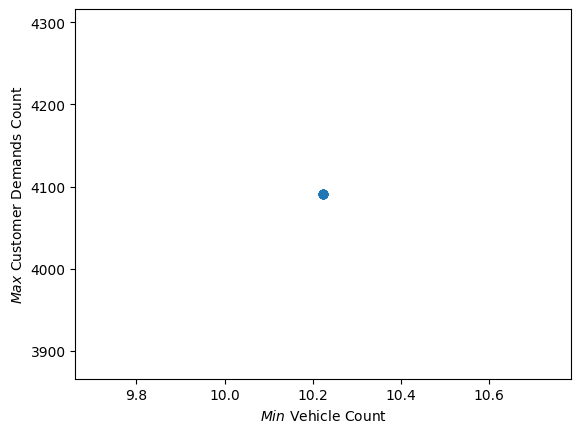

In [92]:
_, _, customer_demands_fitness, vehicle_count_fitness = get_original_fitnesses(problem3_pop_moea.values, 
                                                                                            p3_data, 
                                                                                            problem3_depot_location_dict)

plt.scatter(vehicle_count_fitness , customer_demands_fitness)
plt.ylabel('$Max$ Customer Demands Count')
plt.xlabel('$Min$ Vehicle Count')
plt.show()

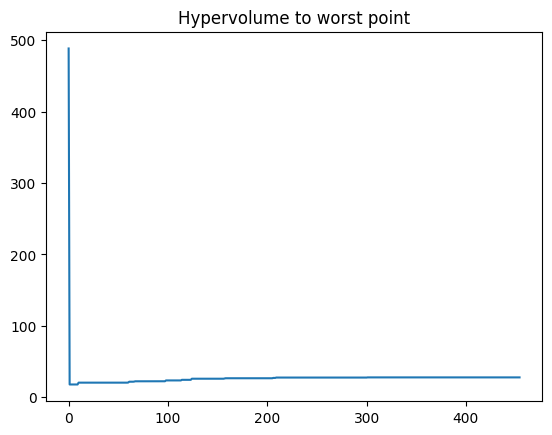

In [93]:
## based on worst point
plt.plot(problem3_hv_moea)
plt.title('Hypervolume to worst point')
plt.show()

z axis is Customer served demands Count fitness
y axis is with distance penalty


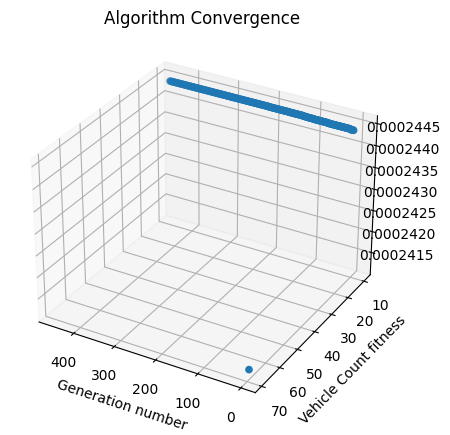

In [94]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Algorithm Convergence')
ax.scatter(problem3_opts_moea.index.values, problem3_opts_moea[0].values, problem3_opts_moea[1].values)
ax.view_init(30, 120)
ax.set_xlabel('Generation number')
ax.set_ylabel('Vehicle Count fitness')
# ax.set_zlabel('Customer served demands Count fitness')
print('z axis is Customer served demands Count fitness')
print('y axis is with distance penalty')
plt.show()

In [95]:
problem3_opts_moea.head(), problem3_pop_moea.head()

(           0         1
 0  69.027971  0.000241
 1  11.215714  0.000244
 2  11.215714  0.000244
 3  11.215714  0.000244
 4  11.215714  0.000244,
                                                    0
 0  (3)1871452342491961921541811851522441841902112...
 1  (3)1871452342491961921541811851522441841902112...
 2  (3)1871452342491961921541811851522441841902112...
 3  (3)1871452342491961921541811851522441841902112...
 4  (3)1871452342491961921541811851522441841902112...)

In [99]:
problem3_pop_moea.iloc[4].values[0], '' ,problem3_pop_moea.iloc[8].values[0]

('(3)187145234249196192154181185152244184190211242237170212108203151250156202247166133179138165161122135162215178183172217198209140132231144200139214111105136216120149114106208157124101225130147193112204148240176113228188205168116131155117137243150177241119220146(3)|(3)197222103125235206175115129141159186201223219158167180194207173128134104236232226224221199127123163(3)|(3)248109126118143164213246239110171218(3)|(3)229191107(3)|(3)',
 '',
 '(3)187145234249196192154181185152244184190211242237170212108203151250156202247166133179138165161122135162215178183172217198209140132231144200139214111105136216120149114106208157124101225130147193112204148240176113228188205168116131155117137243150177241119220146(3)|(3)197222103125235206175115129141159186201223219158167180194207173128134104236232226224221199127123163(3)|(3)248109126118143164213246239110171218(3)|(3)229191107(3)|(3)')

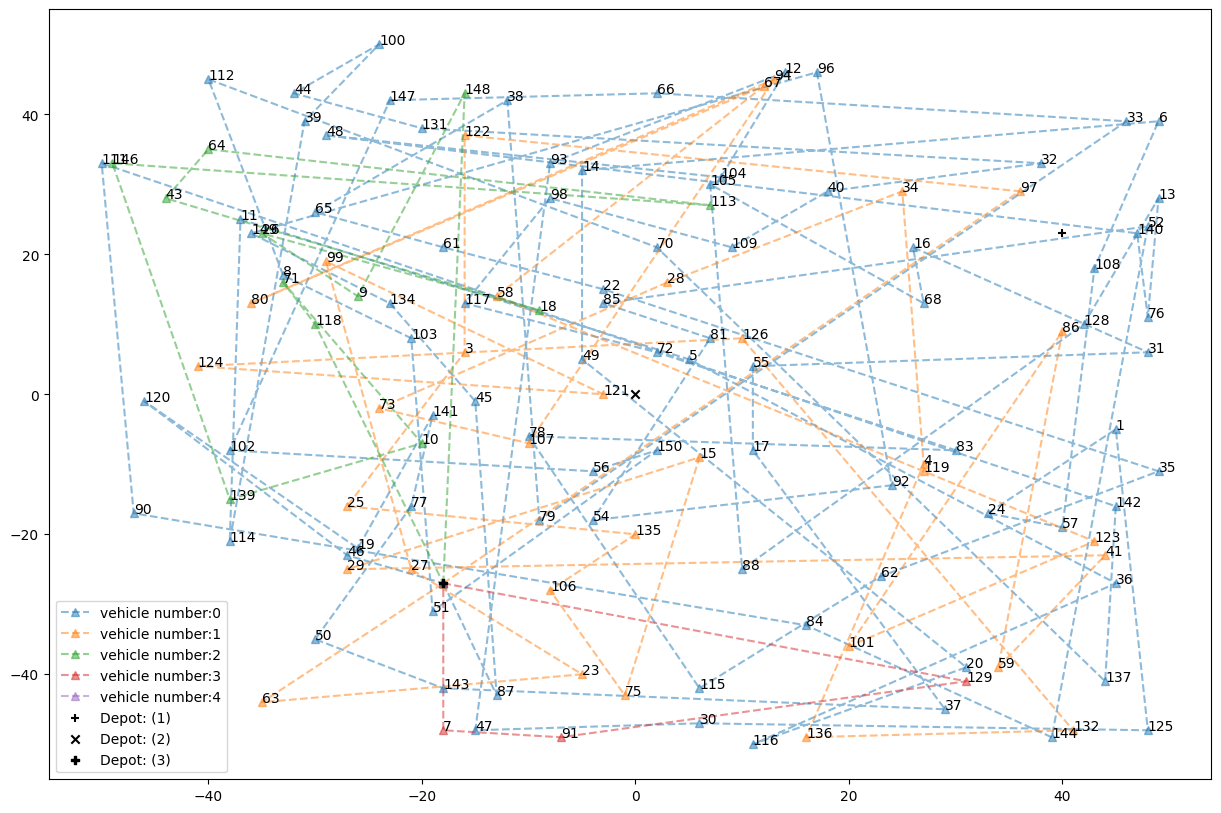

In [187]:
plot_result(p3_data, problem3_pop_moea.iloc[4].values[0], problem3_depot_location_dict, legend=True)


### Problem 3 NSGA-II and MOEA/D comparison

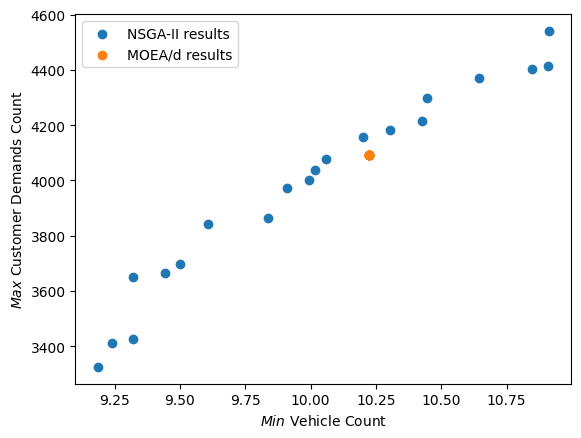

In [123]:
_, _, customer_demands_fitness, vehicle_count_fitness = get_original_fitnesses(problem3_pop.values, 
                                                                                            p3_data, 
                                                                                            problem3_depot_location_dict)
_, _, customer_demands_fitness_moea, vehicle_count_fitness_moea = get_original_fitnesses(problem3_pop_moea.values, 
                                                                                            p3_data, 
                                                                                            problem3_depot_location_dict)
plt.scatter(vehicle_count_fitness, customer_demands_fitness,  label='NSGA-II results')
plt.scatter(vehicle_count_fitness_moea, customer_demands_fitness_moea,  label='MOEA/d results')
plt.legend()
plt.ylabel('$Max$ Customer Demands Count')
plt.xlabel('$Min$ Vehicle Count')
plt.show()

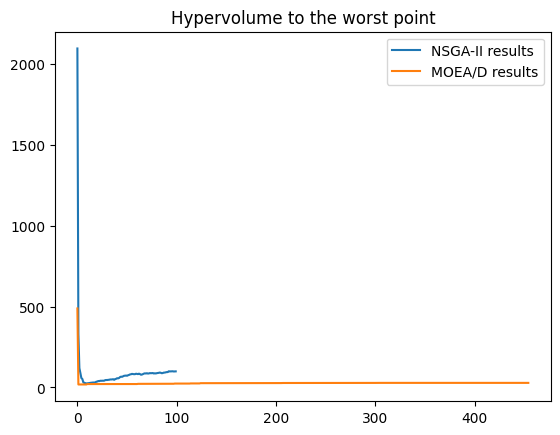

In [125]:
## based on worst point
plt.plot(problem3_hv, label='NSGA-II results')
plt.plot(problem3_hv_moea, label='MOEA/D results')
plt.title('Hypervolume to the worst point')
plt.legend()
plt.show()

z axis is Customer demands served Count fitness


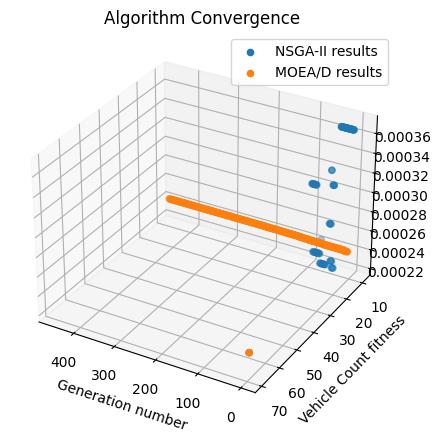

In [134]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Algorithm Convergence')
ax.scatter(problem3_opts.index.values, problem3_opts[0].values, problem3_opts[1].values, label='NSGA-II results')
ax.scatter(problem3_opts_moea.index.values, problem3_opts_moea[0].values, problem3_opts_moea[1].values, label='MOEA/D results')
ax.view_init(30, 120)
ax.set_xlabel('Generation number')
ax.set_ylabel('Vehicle Count fitness')
# ax.set_zlabel('')
print('z axis is Customer demands served Count fitness')
plt.legend()
plt.show()

it seems all chromosomes are the same in moea/d algorithm as we can see in the cell below. the reason is that there is no elimination of repetetive chromsomes in this algorithm.

In [135]:
problem3_pop_moea[:5].values

array([['(3)187145234249196192154181185152244184190211242237170212108203151250156202247166133179138165161122135162215178183172217198209140132231144200139214111105136216120149114106208157124101225130147193112204148240176113228188205168116131155117137243150177241119220146(3)|(3)197222103125235206175115129141159186201223219158167180194207173128134104236232226224221199127123163(3)|(3)248109126118143164213246239110171218(3)|(3)229191107(3)|(3)'],
       ['(3)187145234249196192154181185152244184190211242237170212108203151250156202247166133179138165161122135162215178183172217198209140132231144200139214111105136216120149114106208157124101225130147193112204148240176113228188205168116131155117137243150177241119220146(3)|(3)197222103125235206175115129141159186201223219158167180194207173128134104236232226224221199127123163(3)|(3)248109126118143164213246239110171218(3)|(3)229191107(3)|(3)'],
       ['(3)187145234249196192154181185152244184190211242237170212108203151250156202247166133179138165161122

In [166]:
evaluate_fitness_vehicle_count(problem3_pop_moea.values[0, 0], 
                        problem3_depot_location_dict['(3)'], 
                        p3_data)

10.224

In [168]:
evaluate_fitness_customers_served_demands(problem3_pop_moea.values[0, 0], 
                        problem3_depot_location_dict['(3)'], 
                        p3_data, normalize=False)

4091

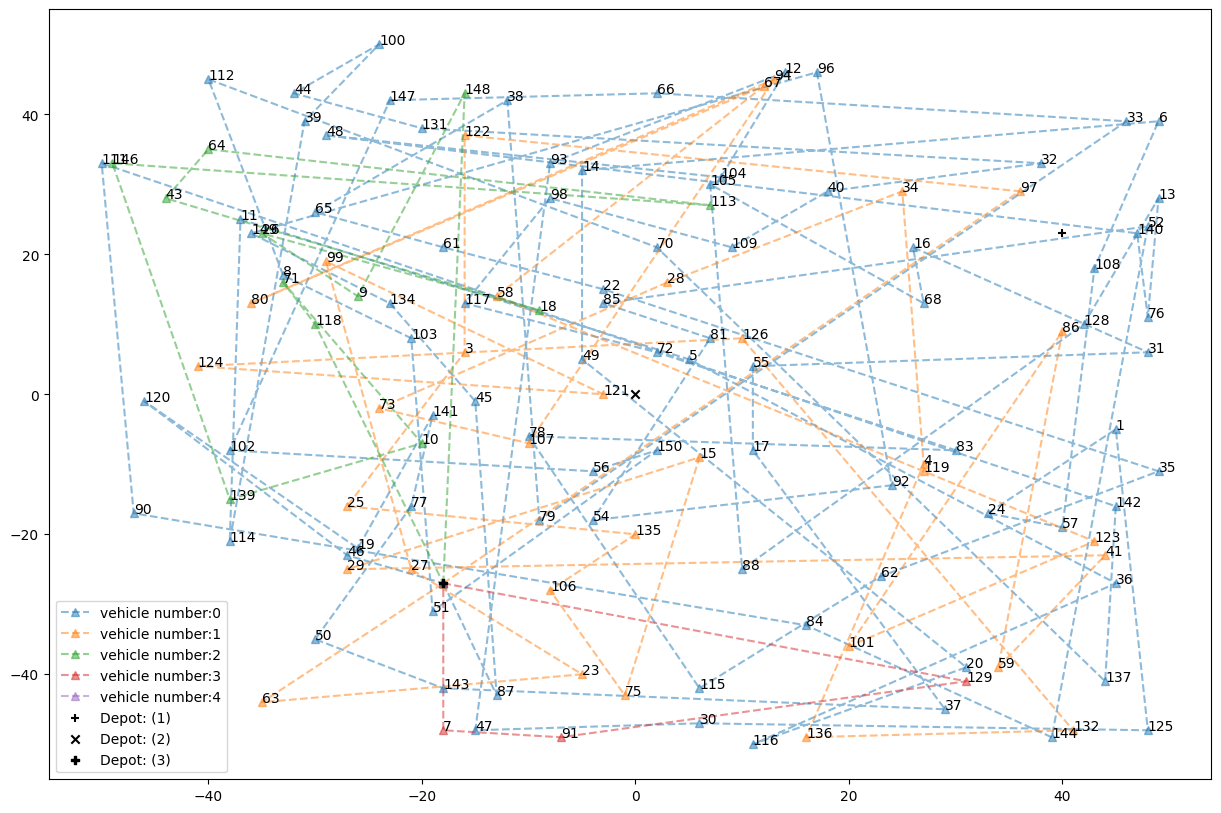

In [184]:
plot_result(p3_data, problem3_pop_moea.values[0, 0], DEPOT_LOCATIONS_dict, legend=True)
